In [1]:
# Imports
library(Seurat)
library(SingleCellExperiment)
library(SingleR)
library(celldex)    
library(ggplot2)
library(clustree)
library(gridExtra)
library(stringr) 
library(scDblFinder)
library(dplyr)

# Change setting for visualizing plots within VSCODE
options(repr.plot.width=20, repr.plot.height=12)

Warning message:
"package 'Seurat' was built under R version 4.4.2"
Loading required package: SeuratObject

Warning message:
"package 'SeuratObject' was built under R version 4.4.2"
Loading required package: sp

Warning message:
"package 'sp' was built under R version 4.4.2"

Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, t


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats

Warning message:
"package 'matrixStats' was built under R version 4.4.2"

Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, 

In [22]:
# Function to use ScDblFinder to find doublets
remove_seurat_doublets <- function(seurat_object) {
    # To be able to use ScDBIFinder, we need to convert it to SCE
    sce_object <- as.SingleCellExperiment(seurat_object)
    
    # Run scDblFinder function
    sce_object <- scDblFinder(sce_object)

    # View table
    table(sce_object$scDblFinder.class)

    # as.Seurat needs logcounts but we dont want to calculate log counts, to trick we assume sce logcounts = counts
    logcounts(sce_object) <- assay(sce_object, "counts")

    # Convert SCE object back to Seurat
    seurat_object <- as.Seurat(sce_object)
    seurat_object <- subset(seurat_object, subset = scDblFinder.class == "singlet")
    seurat_object[["RNA"]] <- as(seurat_object[["RNA"]], "Assay5")
    return(seurat_object)
}

In [ ]:
# Set wd
setwd("../../../Data/R Objects/Raw Seurat R Objects")

# Read in data
Cochaine <- readRDS("Cochaine_raw_modified_orig.rds")
Vafadarnejad <- readRDS("Vafadarnejad_raw_modified_orig.rds")
Winkels <- readRDS("Winkels_raw_modified_orig.rds")

# For the following layers to work, we first need to JoinLayers of each individual object
# Merge layers
Cochaine[["RNA"]] <- JoinLayers(Cochaine[["RNA"]])
Vafadarnejad[["RNA"]] <- JoinLayers(Vafadarnejad[["RNA"]])
Winkels[["RNA"]] <- JoinLayers(Winkels[["RNA"]])

# Remove doublets from individual samples
# To add reproducability in the future, consider adding BPARAM = bp, where bp = Multicore(n, seed)
Cochaine <- remove_seurat_doublets(Cochaine)
Vafadarnejad <- remove_seurat_doublets(Vafadarnejad)
Winkels <- remove_seurat_doublets(Winkels)

# Winkels has gene names in caps, so we need to fix that 
rownames(Winkels) <- tolower(rownames(Winkels))
rownames(Winkels) <- str_to_title(rownames(Winkels))

# Change this later
rownames(Winkels) <- ifelse(grepl("^Mt-", rownames(Winkels)), tolower(rownames(Winkels)), rownames(Winkels))


# Merge the Seurat objects
sc.data <- merge(Cochaine, y=list(Vafadarnejad, Winkels))

# Merge layers
sc.data[["RNA"]] <- JoinLayers(sc.data[["RNA"]])

[1] "all_mice_macrophages_annotated.rds"         
 [2] "all_mice_myeloid_data.rds"                  
 [3] "Bashore_raw.rds"                            
 [4] "Cochaine_raw.rds"                           
 [5] "Cochaine_raw_modified_orig.rds"             
 [6] "Dib_and_Horstmann_macrophages_annotated.rds"
 [7] "Dib_macrophages_annotated.rds"              
 [8] "Dib_raw.rds"                                
 [9] "Fernandez_raw.rds"                          
[10] "Horstmann_macrophages_annotated.rds"        
[11] "Horstmann_raw.rds"                          
[12] "Menno_raw.rds"                              
[13] "menno_raw_postdoublet.rds"                  
[14] "Vafadarnejad_raw.rds"                       
[15] "Vafadarnejad_raw_modified_orig.rds"         
[16] "Winkels_raw.rds"                            
[17] "Winkels_raw_modified_orig.rds"

[1] "c:/Users/phili/Desktop/BMW Jaar 3/Afstudeerscriptie/project_scriptie/Data/R Objects/Raw Seurat R Objects"

[1] "Seurat"
attr(,"package")
[1] "SeuratObject"


Warning message:
"Layer 'data' is empty"
Warning message:
"Layer 'scale.data' is empty"
Creating ~2061 artificial doublets...

Dimensional reduction

Evaluating kNN...

Training model...

iter=0, 366 cells excluded from training.

iter=1, 371 cells excluded from training.

iter=2, 364 cells excluded from training.

Threshold found:0.63

144 (5.6%) doublets called

Warning message:
"Assay RNA changing from Assay to Assay5"
Warning message:
"Layer 'data' is empty"
Warning message:
"Layer 'scale.data' is empty"
Creating ~1500 artificial doublets...

Dimensional reduction

Evaluating kNN...

Training model...

iter=0, 92 cells excluded from training.

iter=1, 86 cells excluded from training.

iter=2, 82 cells excluded from training.

Threshold found:0.655

36 (3.9%) doublets called

Warning message:
"Assay RNA changing from Assay to Assay5"
Warning message:
"Layer 'data' is empty"
Warning message:
"Layer 'scale.data' is empty"
Creating ~2833 artificial doublets...

Dimensional reduction

E

In [ ]:
# Preprocessing function which performs a basic workflow for scRNA seq analysis
pre_process <- function(data, nFeatures_RNA = 200, nCounts_RNA = 3, percents.mt = 5, pattern = "MT", resolutions = seq(0.5, 1.5, by = 0.1), k.weights = 100) {
    # Split
    data[["RNA"]] <- split(data[["RNA"]], f = data$orig.ident)

    # Get percentage mt                     
    data[["percent.mt"]] <- PercentageFeatureSet(data, pattern = sprintf("^%s-", pattern))

    # Subsets
    data <- subset(x = data, subset = nFeature_RNA >= nFeatures_RNA & nCount_RNA >= nCounts_RNA & percent.mt <= percents.mt)

    # Normalization
    data <- NormalizeData(data, normalization.method = "LogNormalize", scale.factor = 10000)
    
    # Find Variable features
    data <- FindVariableFeatures(data, selection.method = "vst", nfeatures = 2000)
    
    # Scale Data
    data <- ScaleData(data, vars.to.regress = c("percent.mt", "nFeature_RNA"))
    
    # Run PCA
    data <- RunPCA(data, npcs = 100, verbose=FALSE)

    # Get significant PCAs through Jackstrawplot
    data <- JackStraw(data, num.replicate = 100)
    data <- ScoreJackStraw(data, dims = 1:20)

    # Check the amount of significant pcs
    significant_pcs <- length(which(data@reductions$pca@jackstraw$overall.p.values < 0.05))

    # Run UMAP
    data <- RunUMAP(data, reduction = "pca", dims = 1:significant_pcs, reduction.name="umap_before_integration", verbose=FALSE)

    # Integrate
    data <- IntegrateLayers(
        object = data, 
        method = CCAIntegration, 
        orig.reduction = "pca", 
        new.reduction = "integrated.cca", 
        k.weight = 
        k.weights,
        verbose = FALSE)

    data[["RNA"]] <- JoinLayers(data[["RNA"]])

    # Post integration processing
    data <- RunPCA(data, npcs = 100, verbose=FALSE)

    # Get significant PCAs through Jackstrawplot
    data <- JackStraw(data, num.replicate = 100)
    data <- ScoreJackStraw(data, dims = 1:20)

    # Check the amount of significant pcs
    significant_pcs <- length(which(data@reductions$pca@jackstraw$overall.p.values < 0.05))

    # Clustering
    data <- FindNeighbors(data, reduction = "integrated.cca", dims = 1:significant_pcs)
    data <- FindClusters(data, resolution = resolutions)
    data <- RunUMAP(data, dims = 1:significant_pcs, reduction = "integrated.cca", verbose=FALSE)

    return(data)
}

data <- pre_process(sc.data, pattern= "mt")

In [44]:
# Save integrated_subset
saveRDS(data, file = "all_mice_integrated.rds")

In [ ]:
# View amount of cells
ncol(data)

[1] 6172

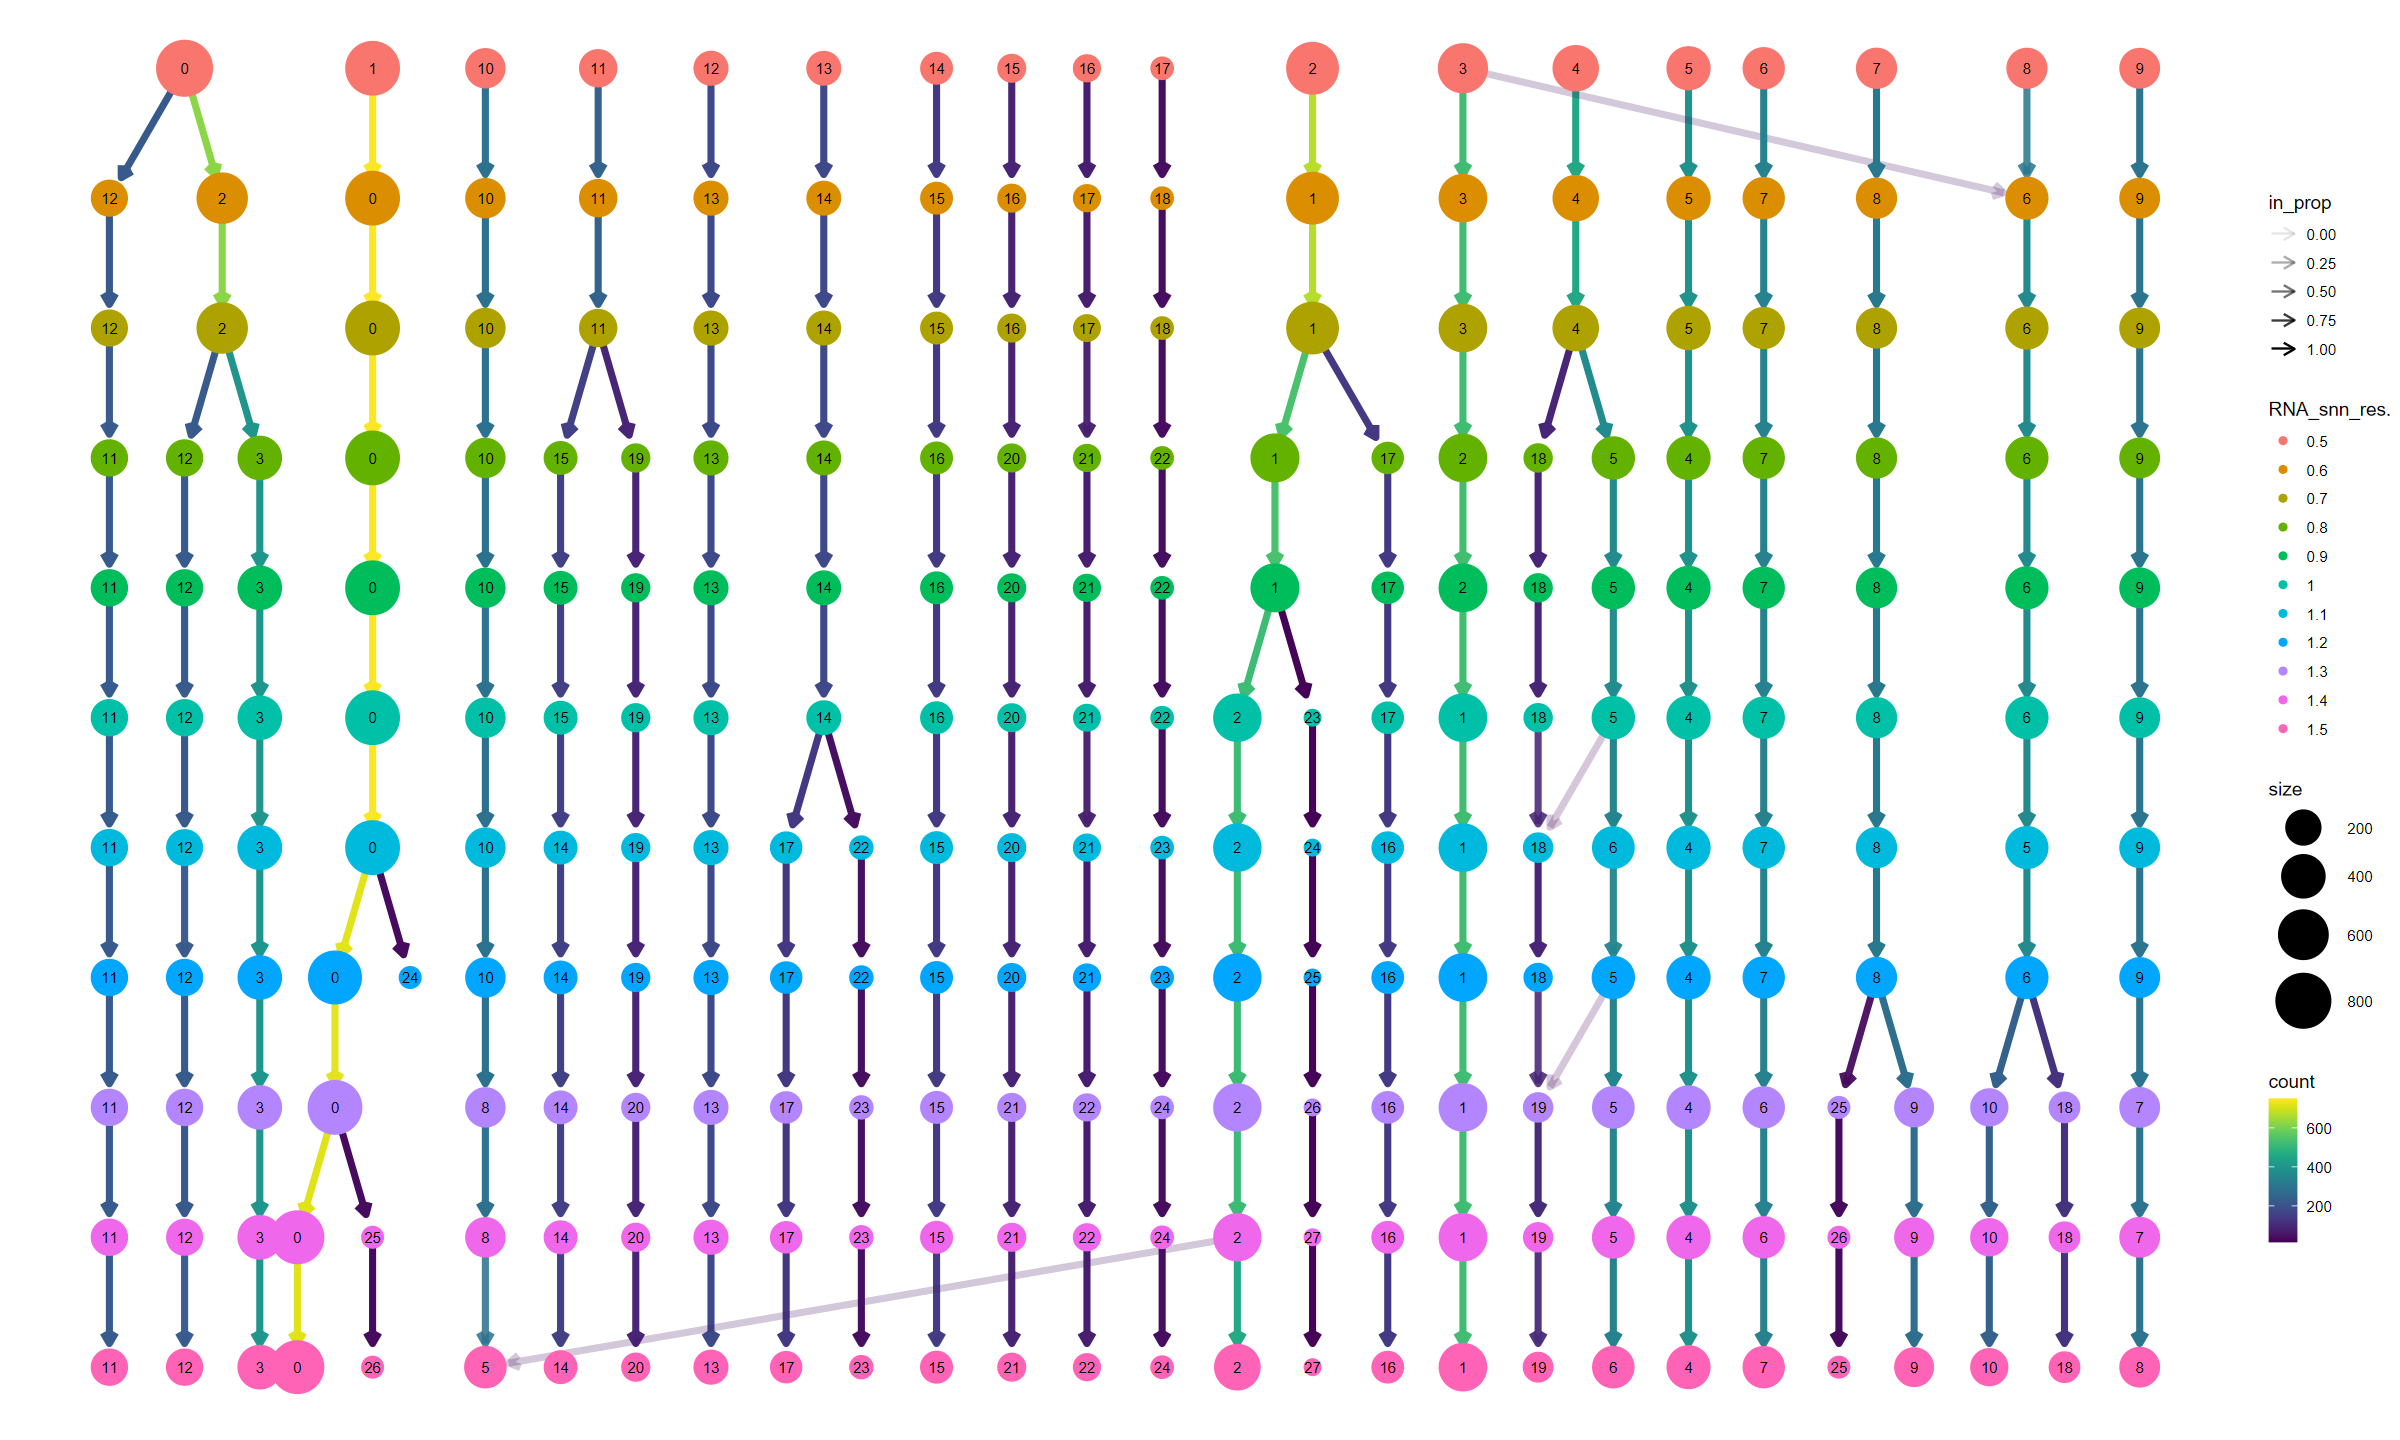

In [4]:
# This cell is meant to analyze the different resolutions and see which one is the best
clustree(data, prefix= "RNA_snn_res.", layout = "sugiyama")

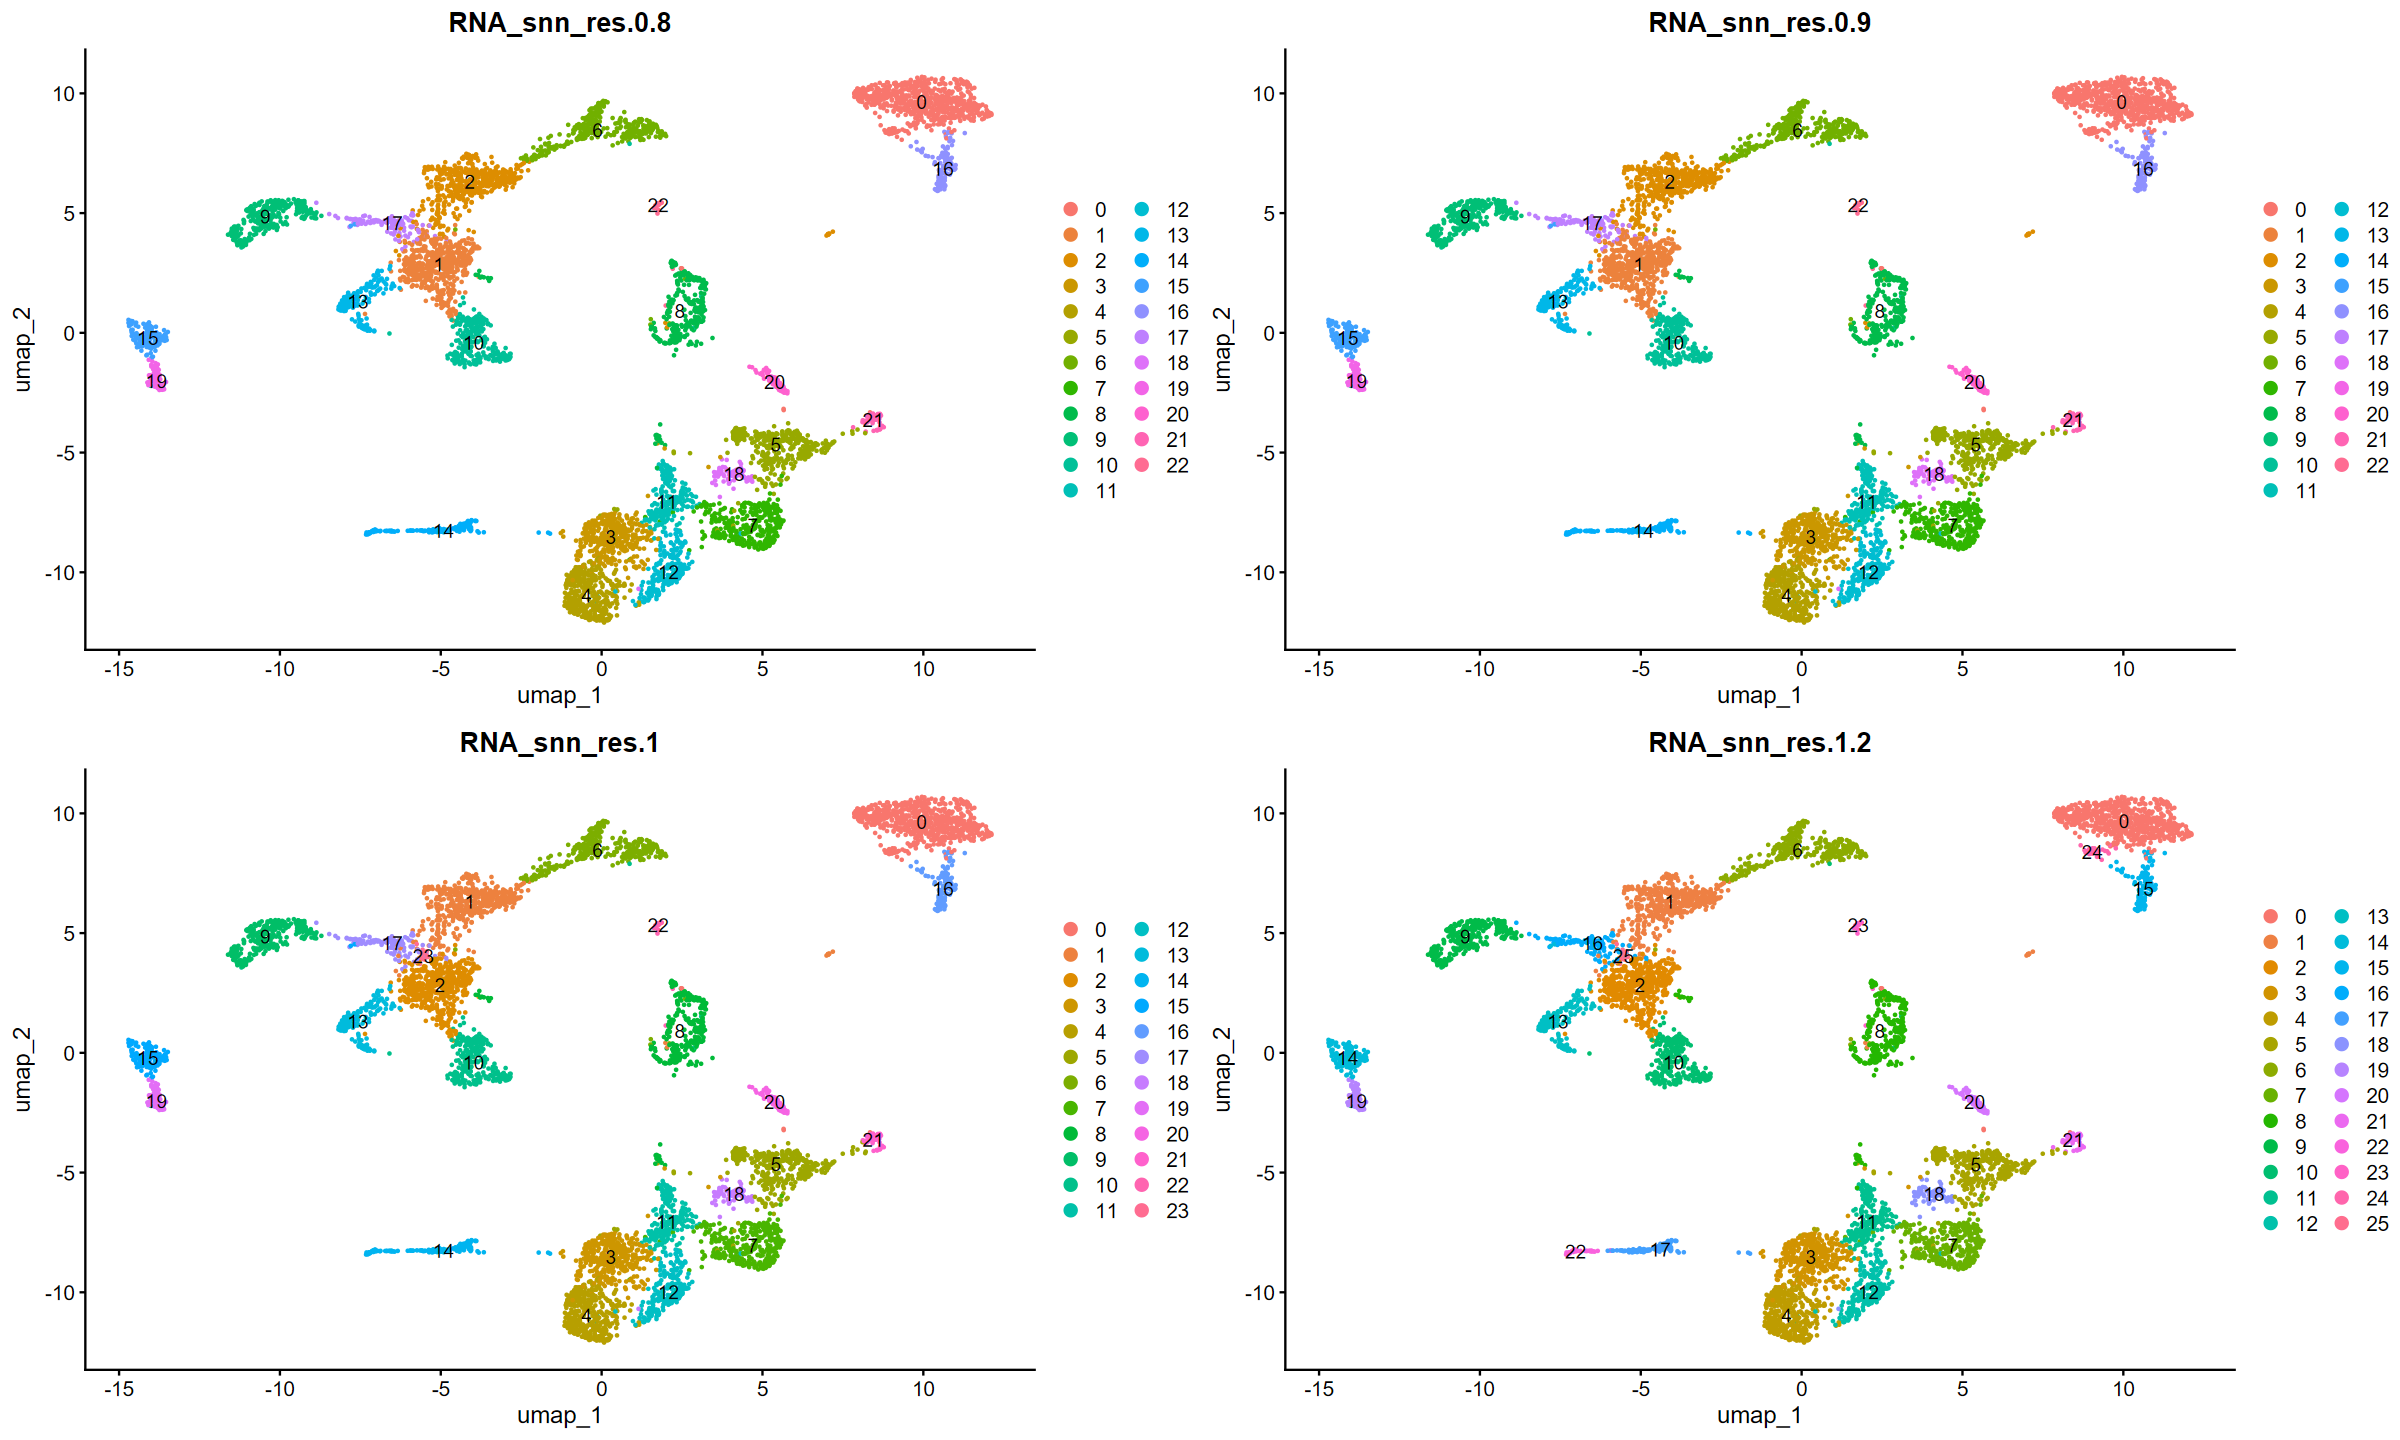

In [ ]:
# Get DimPlots of different resolutions
res_1 <- DimPlot(data, reduction = "umap", group.by = "RNA_snn_res.0.5", label = T)
res_2 <- DimPlot(data, reduction = "umap", group.by = "RNA_snn_res.0.9", label = T)
res_3 <- DimPlot(data, reduction = "umap", group.by = "RNA_snn_res.1", label = T)
res_4 <- DimPlot(data, reduction = "umap", group.by = "RNA_snn_res.1.2", label = T)

# Plot
grid.arrange(res_1, res_2, res_3, res_4, ncol=2)

In [ ]:
# Set resolution
data$seurat_clusters <- data$`RNA_snn_res.1`

0   1   2   3   4   5   6   7   8   9   ⋯ 18  19 20 21 22 23 24
B cells         714   0   0   0   0   0   3   1   0   2 ⋯   0  0  0  0  3  1  0
Dendritic cells   0   1   0   0   0   0   3   1   0   0 ⋯   0  0  0  0 10  0  0
Erythrocytes      1   7   0   0   0   1   0   0   0   0 ⋯   0  0  0  0  0  0  0
Fibroblasts       0   0   0   0   0   0   0   0   0   0 ⋯   0  0  0  0  0  0  0
Granulocytes      0   0   0   0   0   0   0   1   0   0 ⋯   0  0  0  0  0 40  0
Macrophages       0   0   0 365 380   1   5  34   0   0 ⋯   0 36  0  2  8  0  0
Monocytes         0   3   0  39   6   3 331 303   0   0 ⋯   0 73  1 83 46  1  0
NK cells          0   0  38   0   0  35   0   0   2   5 ⋯   0  0 16  0  0  0  0
T cells           0 512 424   0   0 304   2   0 299 272 ⋯ 121  0 67  1  6  0 37
                25 26 27
B cells          0 32  0
Dendritic cells  0  0  0
Erythrocytes     0  0  0
Fibroblasts      0  0  0
Granulocytes     0  0  0
Macrophages     20  0  0
Monocytes       12  1  0
NK cells         0  0  0
T cells          1  0 19

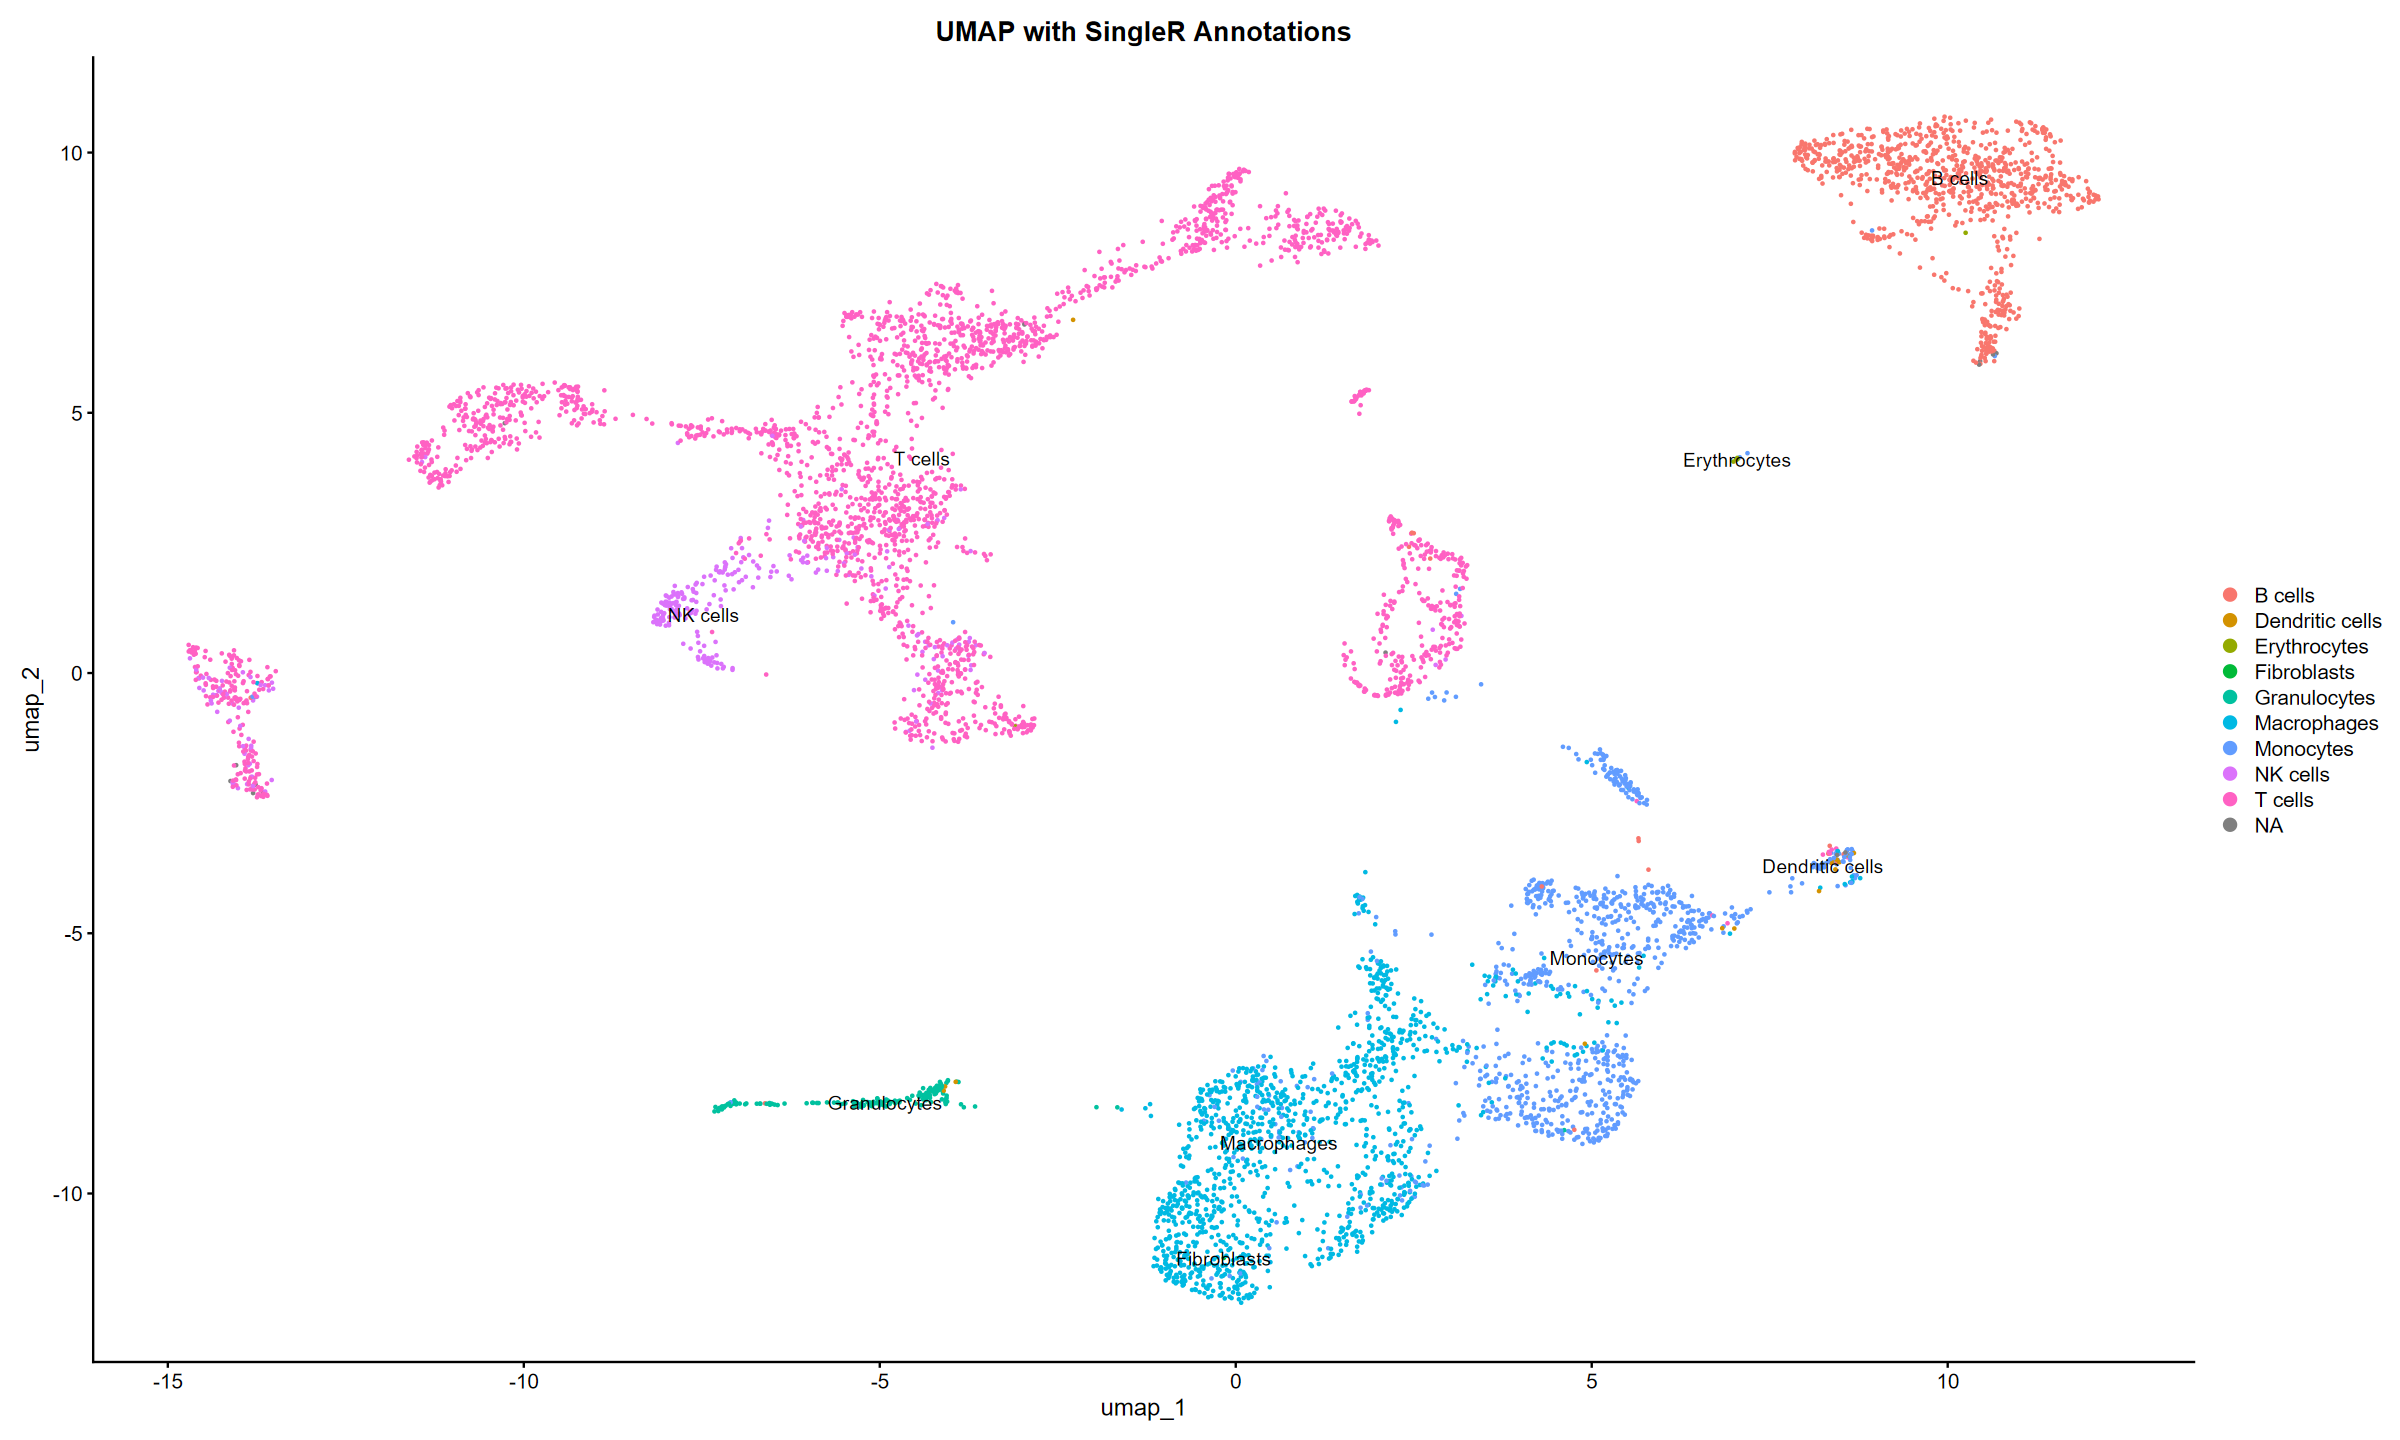

In [ ]:
# Annotation
# Get reference atlas from CellDex
MouseRNAseqData <- celldex::MouseRNAseqData()

# Convert to SCE to use SingleR
data.sce <- as.SingleCellExperiment(data)

# Predict cell types
pred.MouseRNAseqData <- SingleR(test = data.sce, ref = MouseRNAseqData, assay.type.test=1,
    labels = MouseRNAseqData$label.main)

# View annotations
cluster_table <- cbind(table(pred.MouseRNAseqData$pruned.labels,data.sce$seurat_clusters))
cluster_table

# Add SingleR predicted labels to Seurat metadata
data$SingleR_Labels <- pred.MouseRNAseqData$pruned.labels

# UMAP plot with SingleR labels
DimPlot(data, reduction = "umap", group.by = "SingleR_Labels", label = TRUE) + 
    ggtitle("UMAP with SingleR Annotations")

In [ ]:
# View number of identified myeloid cells
myeloids_count <- colSums(cluster_table[rownames(cluster_table) %in% c("Macrophages", "Monocytes", "Dendritic cells"), ])
sum(myeloids_count)

[1] 2219

In [29]:
View(cluster_table)

0   1   2   3   4   5   6   7   8   9   ⋯ 14  15  16  17  18 19
B cells         748   0   0   0   0   3   0   1   2   0 ⋯   1   1 134   0  0  0
Dendritic cells   0   1   0   0   0   3   0   1   0   0 ⋯   4   0   0   0  0  0
Erythrocytes      1   7   0   0   0   0   0   0   0   0 ⋯   0   0   0   0  0  0
Fibroblasts       0   0   0   0   0   0   0   0   0   0 ⋯   0   0   0   0  0  0
Granulocytes      0   0   0   0   0   0   0   1   0   0 ⋯ 166   0   0   0  0  0
Macrophages       0   0   0 361 384  16   0  34  20   0 ⋯   1   1   0   0 26  0
Monocytes         1   3   0  39   6 345   0 302  10   0 ⋯   1   2   1   0 64  1
NK cells          0   0  40   0   0   0   0   0   5   2 ⋯   1  35   0   2  0 16
T cells           0 514 479   0   0   2 361   0 273 299 ⋯   0 116   0 131  0 67
                20 21 22 23
B cells          0  3  0  0
Dendritic cells  0 10  0  0
Erythrocytes     0  0  0  0
Fibroblasts      0  0  0  0
Granulocytes     0  0  0  0
Macrophages      2  7  0  0
Monocytes       83 44  0  0
NK cells         0  0  0  0
T cells          1  6 37 19

In [ ]:
# Function to get myeloid cells
get_myeloids <- function(data, table, cell_types = c("Macrophages", "Monocytes", "Dendritic cells")) {

    # Find clusters where atleast > 15% is classified as macrophages
    clusters <- which((colSums(cluster_table[rownames(cluster_table) %in% cell_types, ]) / colSums(cluster_table) * 100) > 50) - 1
    
    # Get subsets by first filtering on macrophage dominant clusters
    data <- subset(data, subset = seurat_clusters %in% names(clusters))

    # And then only select the myeloid_cells
    data <- subset(data, subset = SingleR_Labels %in% cell_types)

    return(data)
}

In [ ]:
# Assign cell_types to use as arguments in get_myeloids
cell_types = c("Macrophages", "Monocytes", "Dendritic cells")

# Code to view amount of cells lost due to filtering on myeloid-dominant clusters
#which((colSums(cluster_table[rownames(cluster_table) %in% cell_types, ]) / colSums(cluster_table) * 100) > 50) - 1
#colSums(cluster_table[which(rownames(cluster_table) %in% cell_types), ])

# Get myeloid cells
myeloid_data <- get_myeloids(data)

0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19 
  1   4   0 400 390 364   0 337  30   0   4 221 221   0   6   3   1   0  90   1 
 20  21  22  23 
 85  61   0   0

In [ ]:
# View amount of myeloid cells
ncol(myeloid_data)

[1] 2169

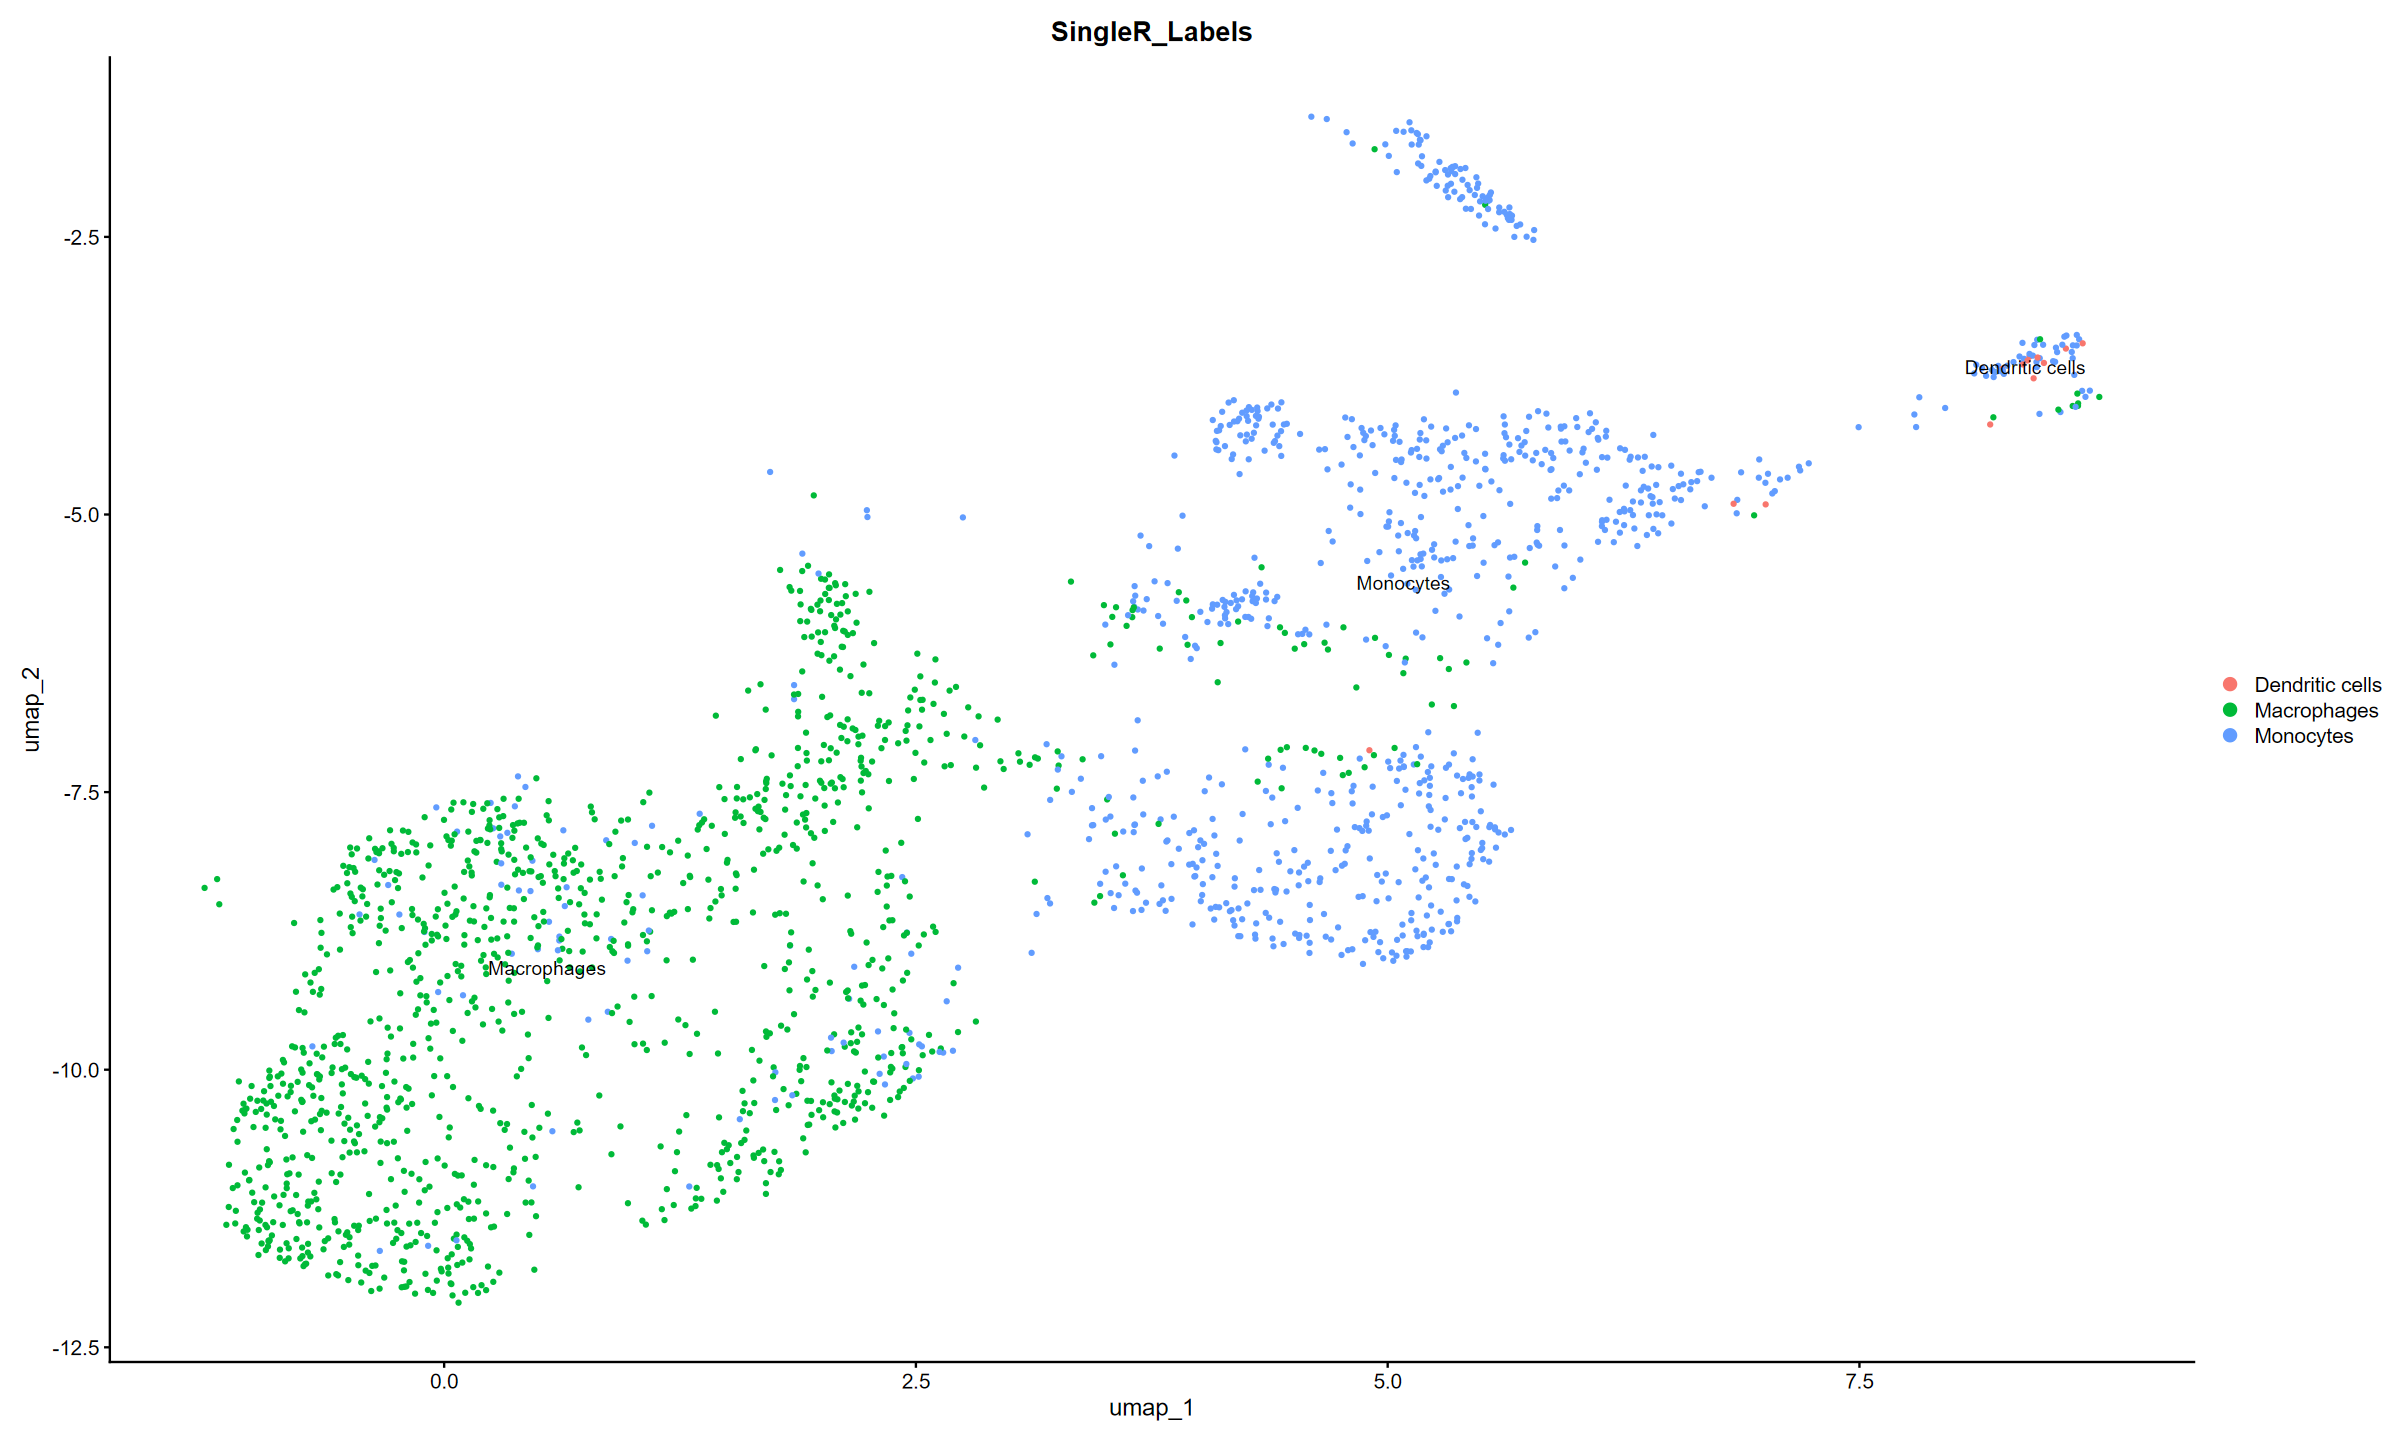

In [ ]:
# DimPlot of SingleR labels on myeloid subset
DimPlot(myeloid_data, reduction="umap", group.by = "SingleR_Labels", label=T)

In [67]:
# Reprocess the subset
# To reintegrate, there needs to be a new Seurat Object created
myeloid_data <- CreateSeuratObject(counts = myeloid_data@assays$RNA$counts)
myeloid_data <- pre_process(myeloid_data, resolutions = seq(0.2, 1.2, by=0.1))

Normalizing layer: counts.HFD/_WD_20

Normalizing layer: counts.HFD_10/11

Normalizing layer: counts.Healthy_CD20,_CD8,_CHOW

Finding variable features for layer counts.HFD/_WD_20

Finding variable features for layer counts.HFD_10/11

Finding variable features for layer counts.Healthy_CD20,_CD8,_CHOW

Regressing out percent.mt, nFeature_RNA

Centering and scaling data matrix

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2169
Number of edges: 73180

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9082
Number of communities: 7
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2169
Number of edges: 73180

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8877
Number of communities: 9
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2169
Number of edges: 73180

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8740
Number of communities: 10
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2169
Number of edges: 73180

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8603
Number of communities: 10
Elapsed time: 0 seconds
Modularity Optimizer v

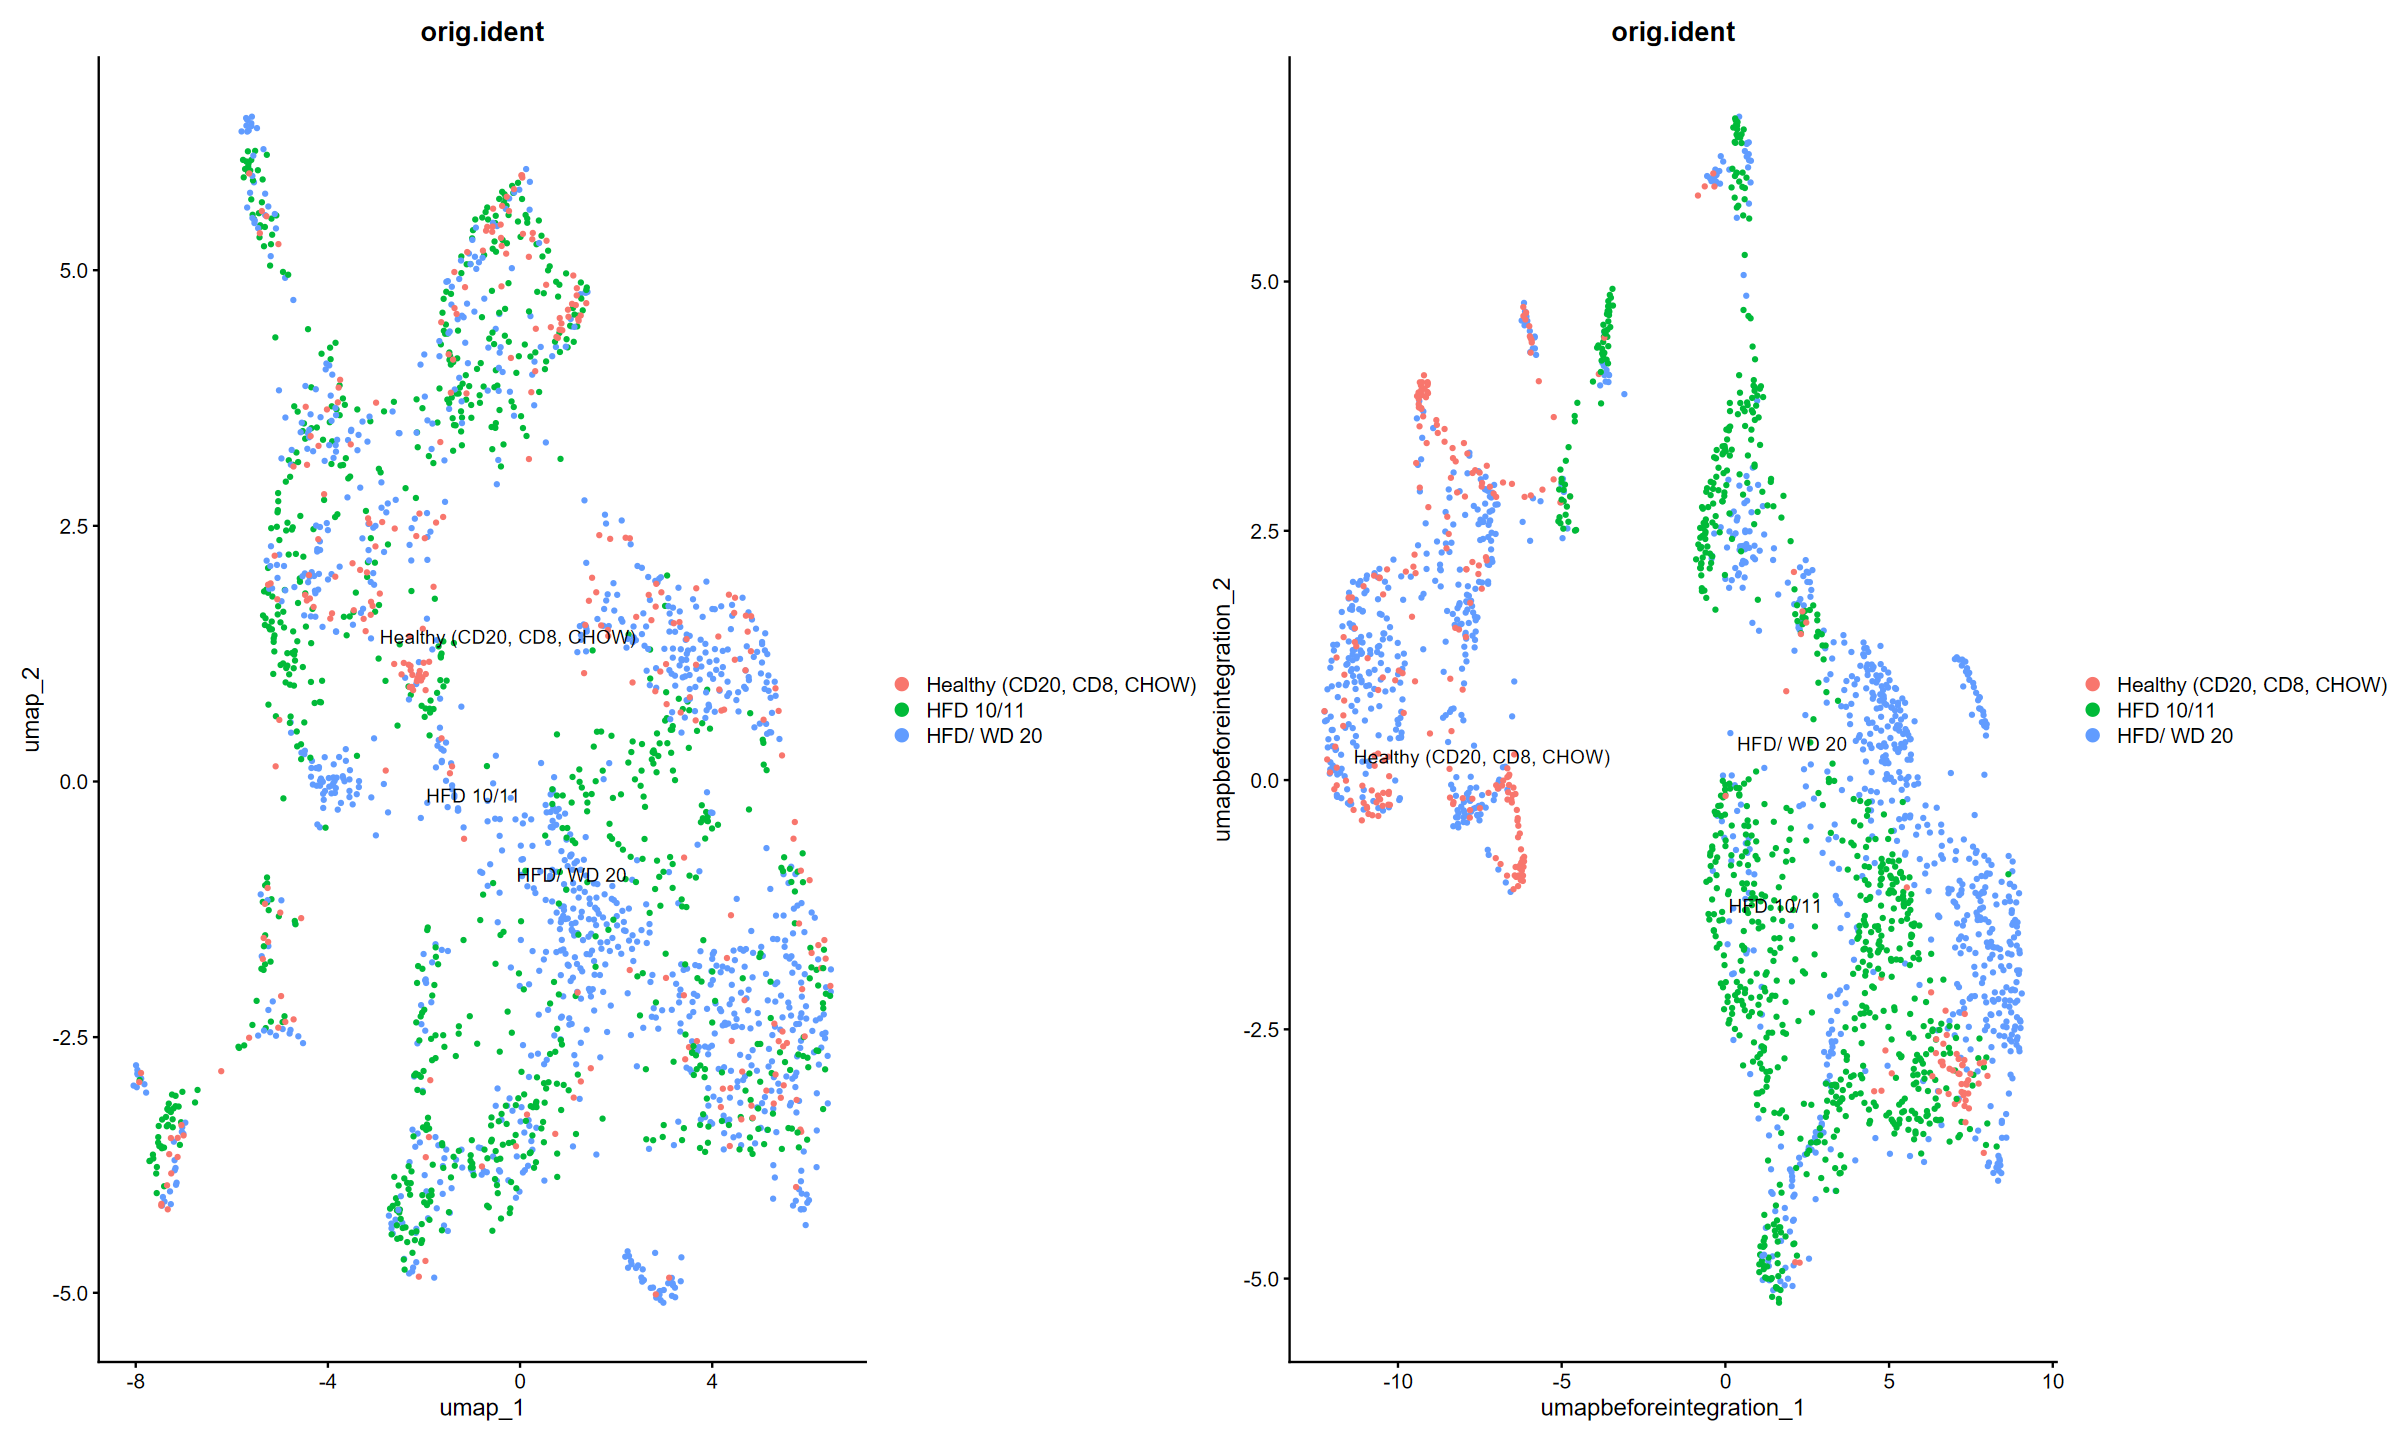

In [ ]:
# Check how well it was integrated 
origins <- DimPlot(myeloid_data, reduction = "umap", group.by = "orig.ident", label = T)
before_integration <- DimPlot(myeloid_data, reduction = "umap_before_integration", group.by = "orig.ident", label = T)
origins + before_integration

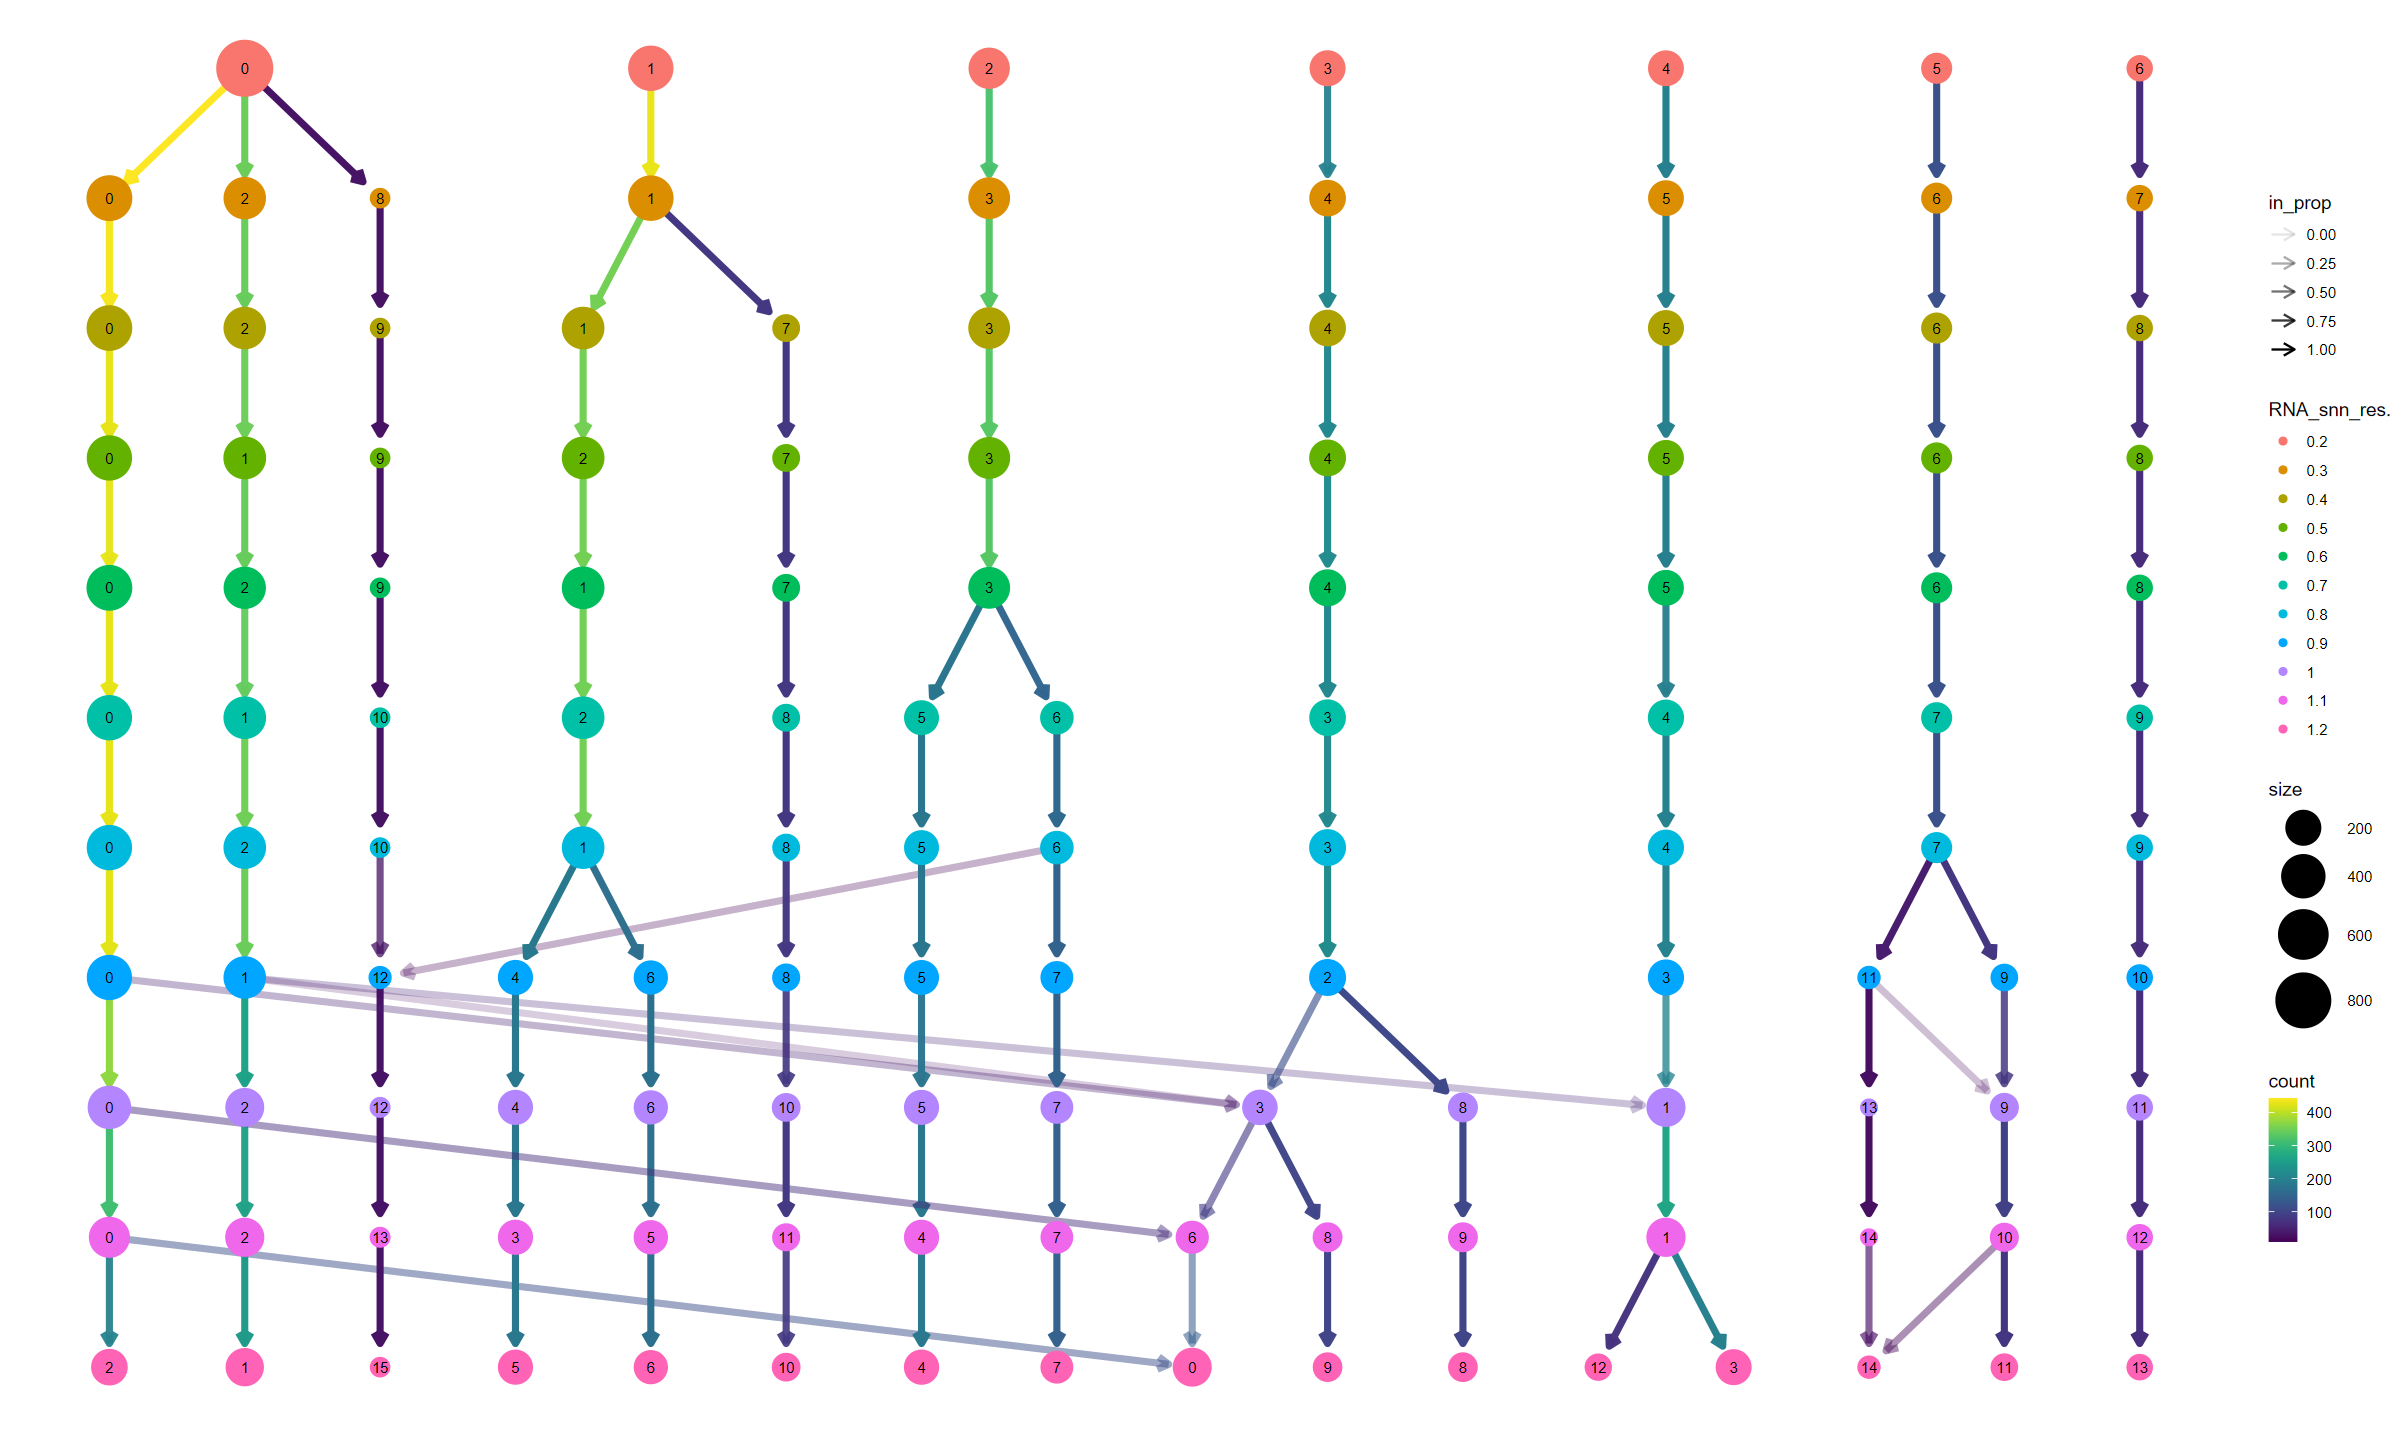

In [69]:
# View the clustree again for the best resolution
clustree(myeloid_data, prefix= "RNA_snn_res.", layout = "sugiyama")

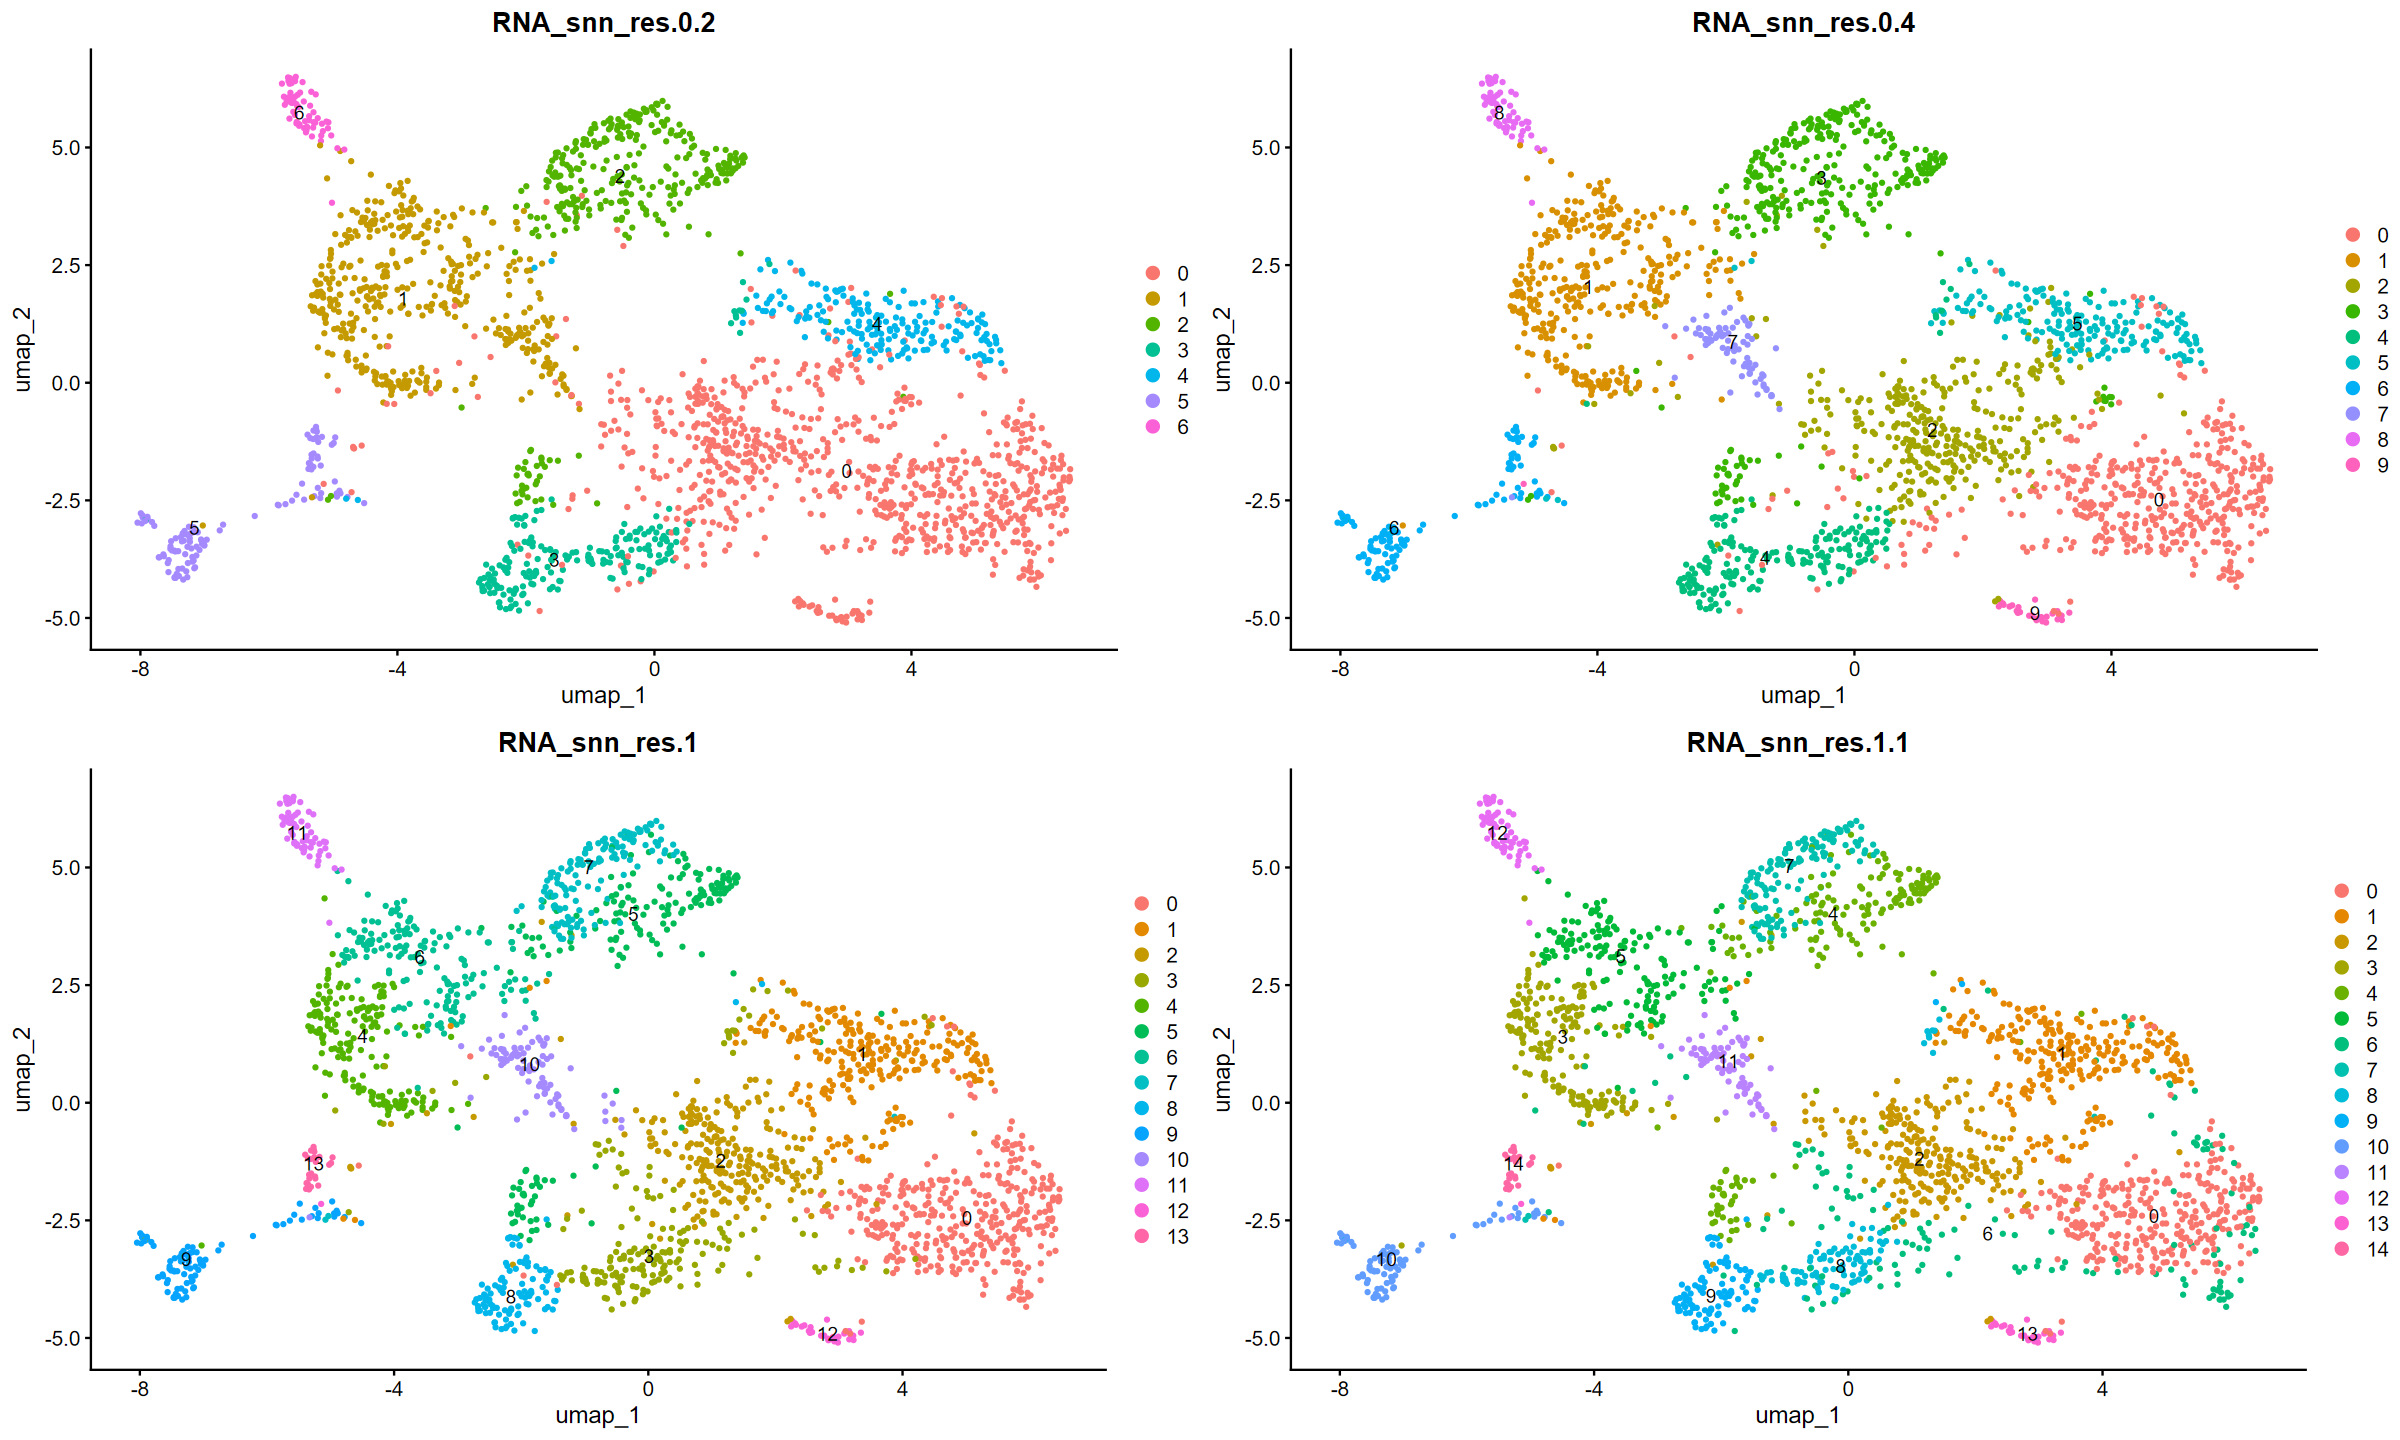

In [71]:
# Assign the slot "Seurat Cluster" to the desired resolution
myeloid_data$seurat_clusters <- myeloid_data$`RNA_snn_res.1.1`
Idents(myeloid_data) <- "seurat_clusters"

# Get DimPlots of different resolutions
res_1 <- DimPlot(myeloid_data, reduction = "umap", group.by = "RNA_snn_res.0.2", label = T)
res_2 <- DimPlot(myeloid_data, reduction = "umap", group.by = "RNA_snn_res.0.4", label = T)
res_3 <- DimPlot(myeloid_data, reduction = "umap", group.by = "RNA_snn_res.1", label = T)
res_4 <- DimPlot(myeloid_data, reduction = "umap", group.by = "RNA_snn_res.1.1", label = T)

# Plot
grid.arrange(res_1, res_2, res_3, res_4, ncol=2)

In [72]:
# Save the data
saveRDS(myeloid_data, "all_mice_myeloid_data_v3.rds")

In [84]:
# Some marker genes according to Winther & Willemsen
features_inflammatory <- c("S100a8", "S100a9", "Il1b", "Casp1", "Casp4", "Nlrp3", "Tnf", "Egr1", "Zpf36", "Ier3", "Cepbp", "Cxcl2", "Ccl2-5")
features_resident <- c("Lyve1", "Cx3cr1", "Folr2", "C1qa", "C1qb", "C1qc", "Cd74", "Hla-dra", "Hla-drb1", "Pf4", "Sepp1", "Vsig4", "F13a1")
features_trem2 <- c("Trem2", "Cd9", "Fabp5", "Apoe", "Apoc1", "Spp1", "Lgals3", "Ctsb")
features_ifnic <- c("Isg15", "Irf7", "Ifit3", "Ifit1")
features_proliferating <- c("Stmn1", "Top2a", "Mki67", "Tuba1b", "Tubb5")

# Add a module score to the Seurat object
myeloid_data <- AddModuleScore(myeloid_data, features = list(features_inflammatory), name = "FeatureGeneScore_inflammatory")
myeloid_data <- AddModuleScore(myeloid_data, features = list(features_resident), name = "FeatureGeneScore_resident_like")
myeloid_data <- AddModuleScore(myeloid_data, features = list(features_trem2), name = "FeatureGeneScore_trem2")

# Vln plots
inflammatory_vln <- VlnPlot(myeloid_data, features = "FeatureGeneScore_inflammatory1", group.by = "seurat_clusters") + 
  ggtitle("FeatureGeneScores for inflammatory macrophage markers")
residents_vln <- VlnPlot(myeloid_data, features = "FeatureGeneScore_resident_like1", group.by = "seurat_clusters") + 
  ggtitle("FeatureGeneScores for resident-like macrophage markers")
trem2_vln <- VlnPlot(myeloid_data, features = "FeatureGeneScore_trem21", group.by = "seurat_clusters") + 
  ggtitle("FeatureGeneScores for trem2 foamy macrophage markers")

# Visualizing DotPlots to view marker genes
inflammatory_dot <- DotPlot(myeloid_data, features = features_inflammatory) + 
  ggtitle("Inflammatory Macrophages") + RotatedAxis()

resident_dot <- DotPlot(myeloid_data, features = features_resident) + 
  ggtitle("Resident-Like Macrophages")

TREM2_dot <- DotPlot(myeloid_data, features = features_trem2) + 
  ggtitle("TREM2 'Foamy' Macrophages")

IFNIC_dot <- DotPlot(myeloid_data, features = features_ifnic) + 
  ggtitle("IFNIC Macrophages")

proliferating_dot <- DotPlot(myeloid_data, features = features_proliferating) + 
  ggtitle("Proliferating Macrophages")


Warning message:
"The following features are not present in the object: Zpf36, Cepbp, Ccl2-5, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: Hla-dra, Hla-drb1, not searching for symbol synonyms"
Warning message:
"The following requested variables were not found: Zpf36, Cepbp, Ccl2-5"
Warning message:
"The following requested variables were not found: Hla-dra, Hla-drb1"


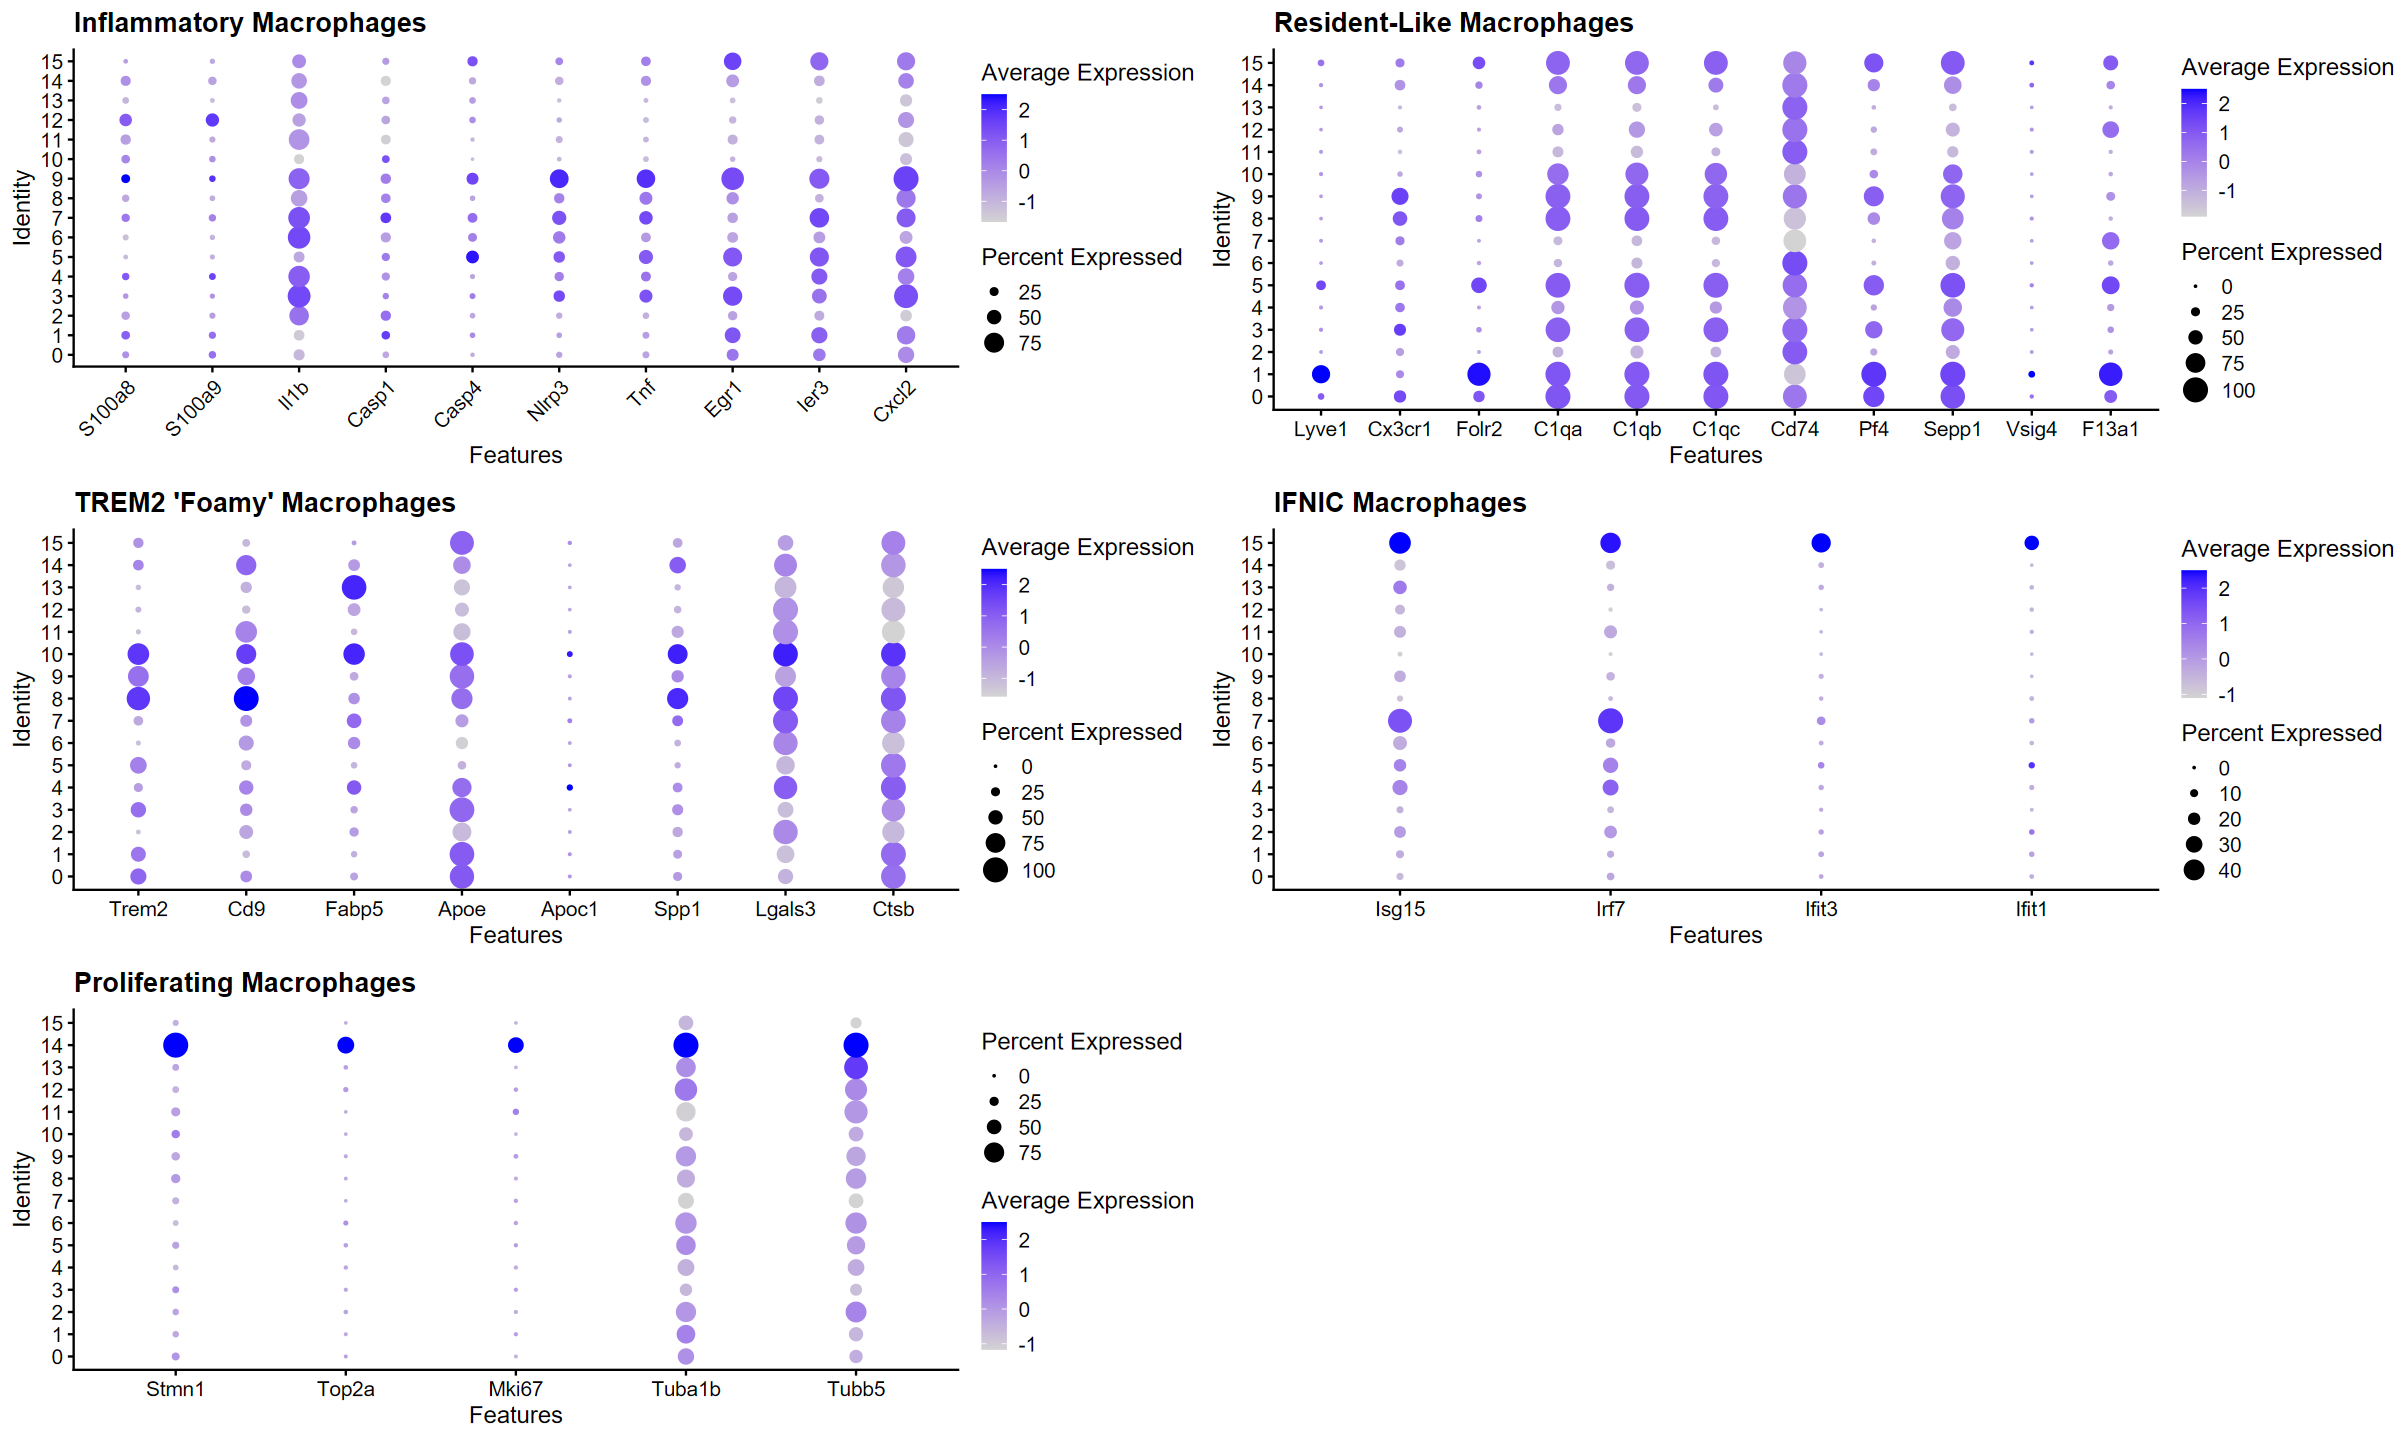

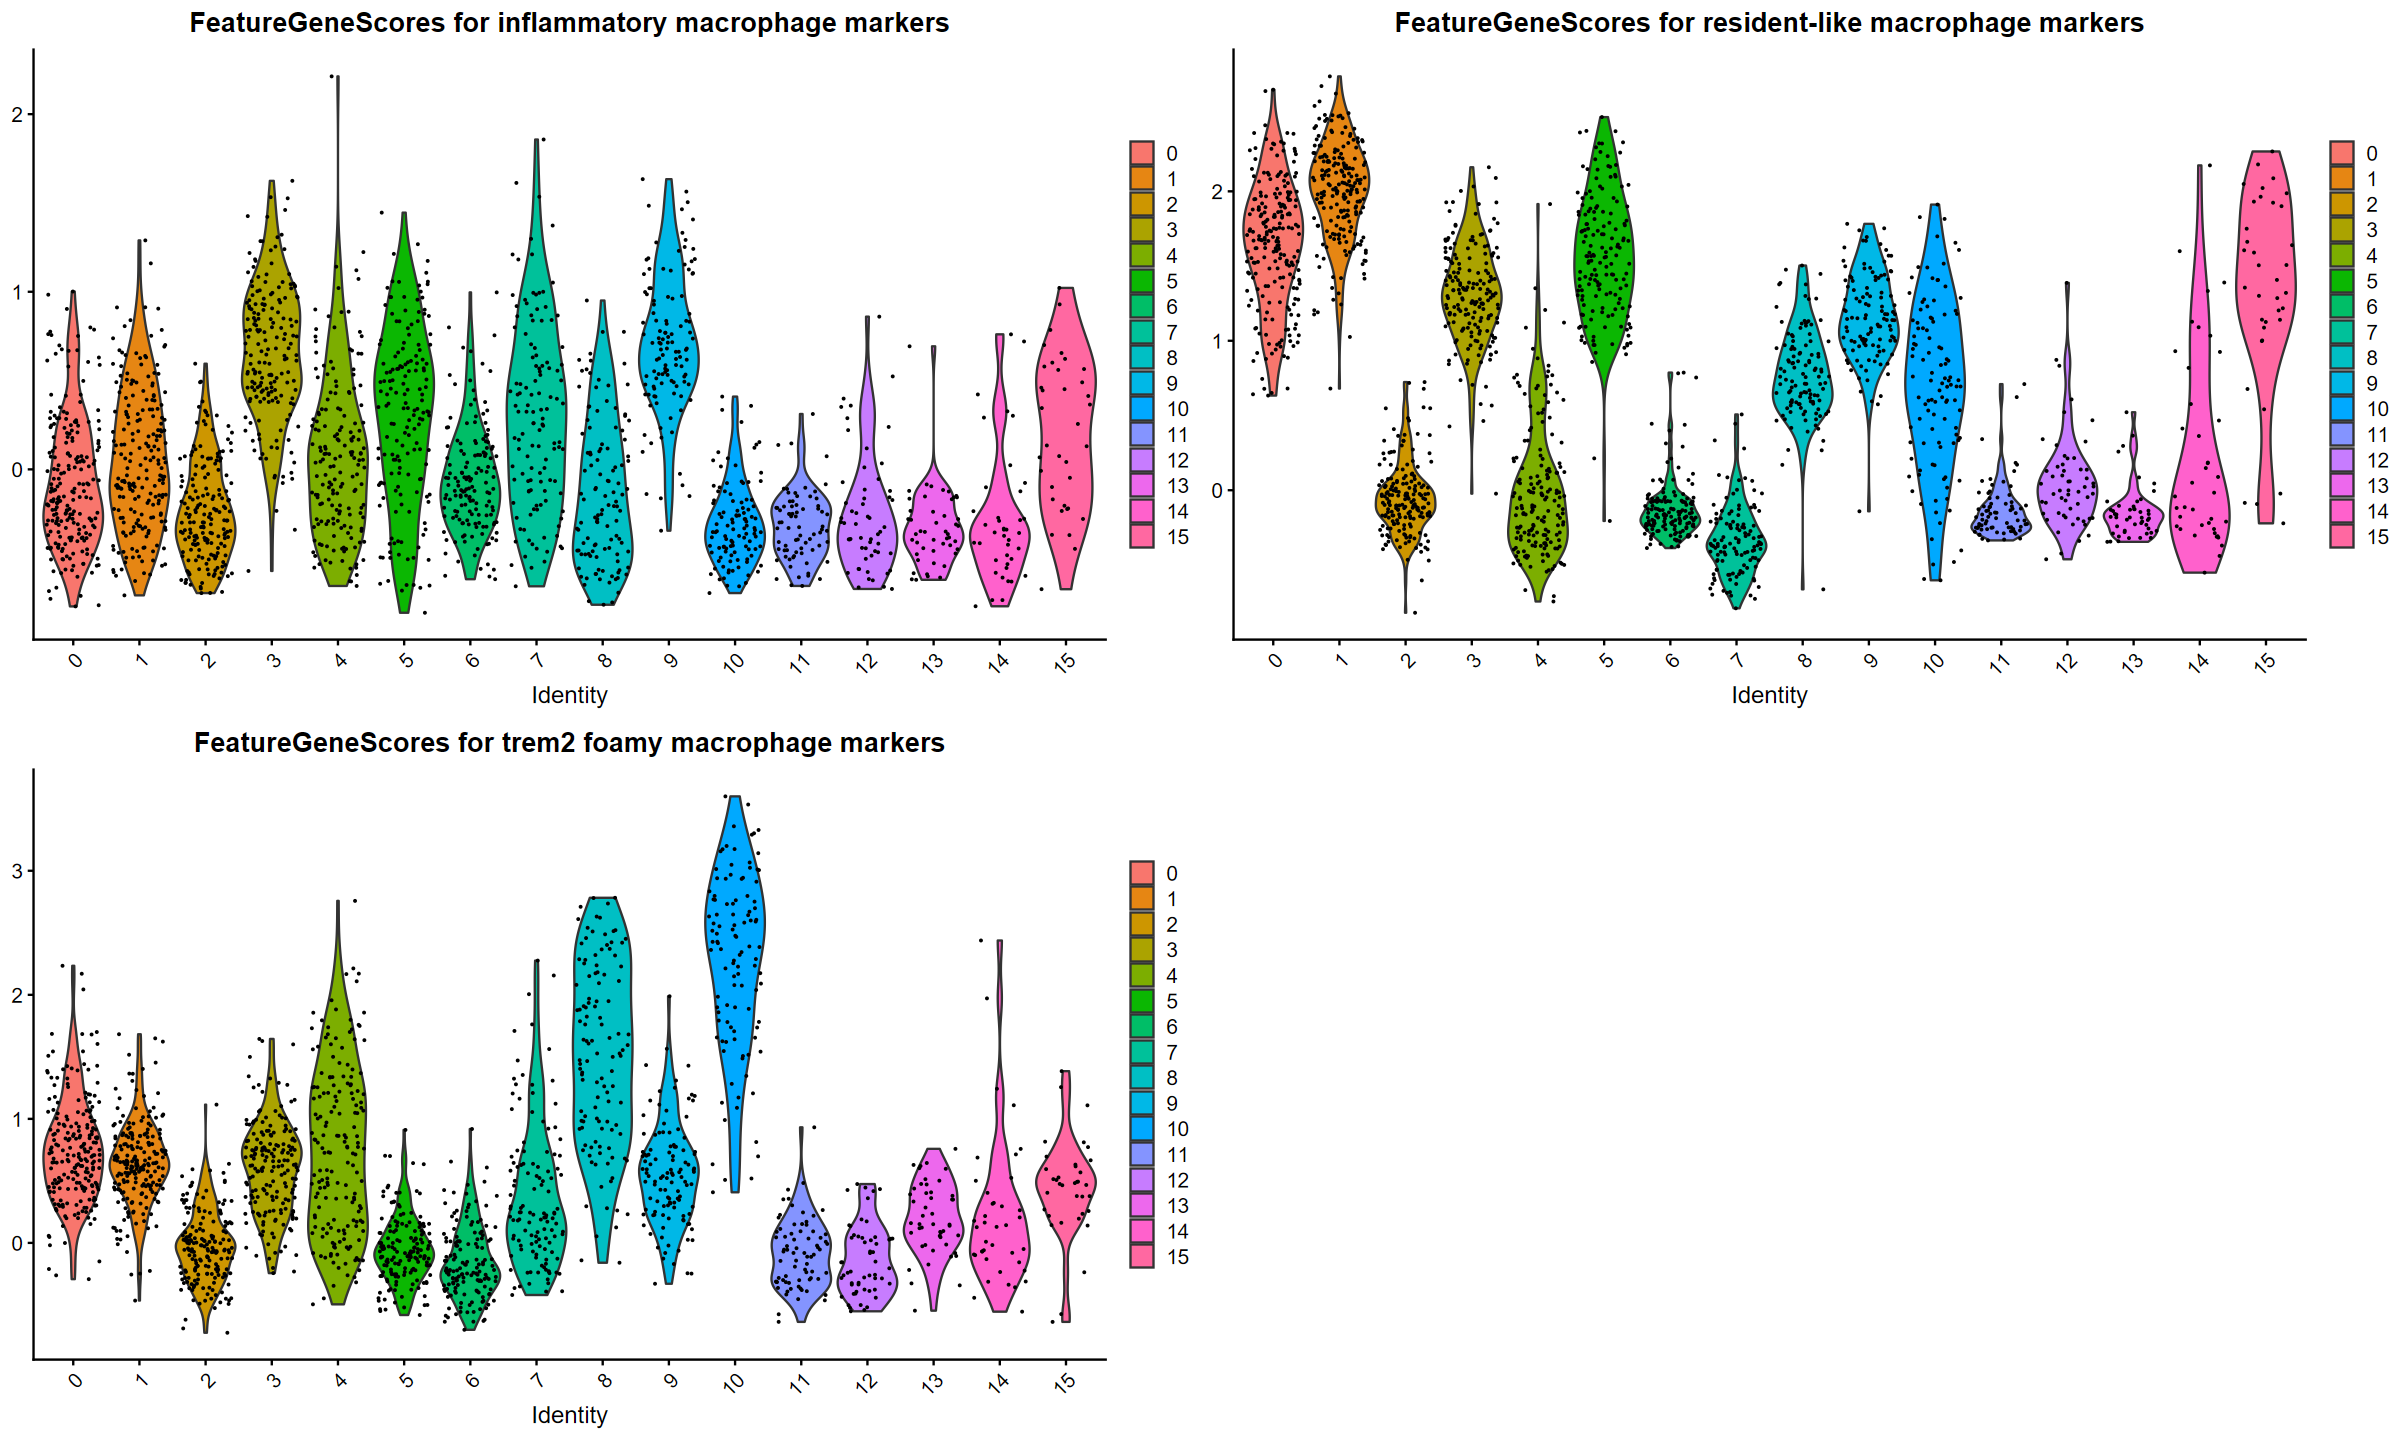

In [86]:
# Plot
grid.arrange(inflammatory_dot, resident_dot, TREM2_dot, IFNIC_dot, proliferating_dot, ncol = 2)
grid.arrange(inflammatory_vln, residents_vln, trem2_vln, ncol=2)


In [35]:
# Assign new labels
myeloid_data <- RenameIdents(myeloid_data,
                                   '0' = 'Resident-like Macrophages',
                                   '1' = 'Inflammatory Macrophages',
                                   '2' = 'Inflammatory Macrophages', 
                                   '3' = 'TREM2 Foamy Macrophages',
                                   '4' = 'Inflammatory Macrophages')

In [36]:
# Proportion tables
annotations_per_origin <- table(Idents(myeloid_data), myeloid_data$orig.ident)
annotations_per_origin_prop <- prop.table(table(Idents(myeloid_data), myeloid_data$orig.ident), margin = 2) * 100
annotations_prop <- prop.table(table(Idents(myeloid_data))) * 100

# Subtype plots after annotation
subtype_annotated_plot <- DimPlot(myeloid_data, reduction = "umap", label = TRUE)
subtype_origin_plot <- DimPlot(myeloid_data, reduction = "umap", group.by = "orig.ident", label = TRUE)

# Combine tables side by side
combined_df <- cbind(annotations_per_origin, annotations_per_origin_prop, annotations_prop)

Healthy (CD20, CD8, CHOW) HFD 10/11 HFD/ WD 20
Resident-like Macrophages 47                        147       269       
Inflammatory Macrophages  70                        140       381       
TREM2 Foamy Macrophages    5                        116        76       
                          Healthy (CD20, CD8, CHOW) HFD 10/11 HFD/ WD 20
Resident-like Macrophages 38.524590                 36.47643  37.05234  
Inflammatory Macrophages  57.377049                 34.73945  52.47934  
TREM2 Foamy Macrophages    4.098361                 28.78412  10.46832  
                          annotations_prop
Resident-like Macrophages 37.01039        
Inflammatory Macrophages  47.24221        
TREM2 Foamy Macrophages   15.74740

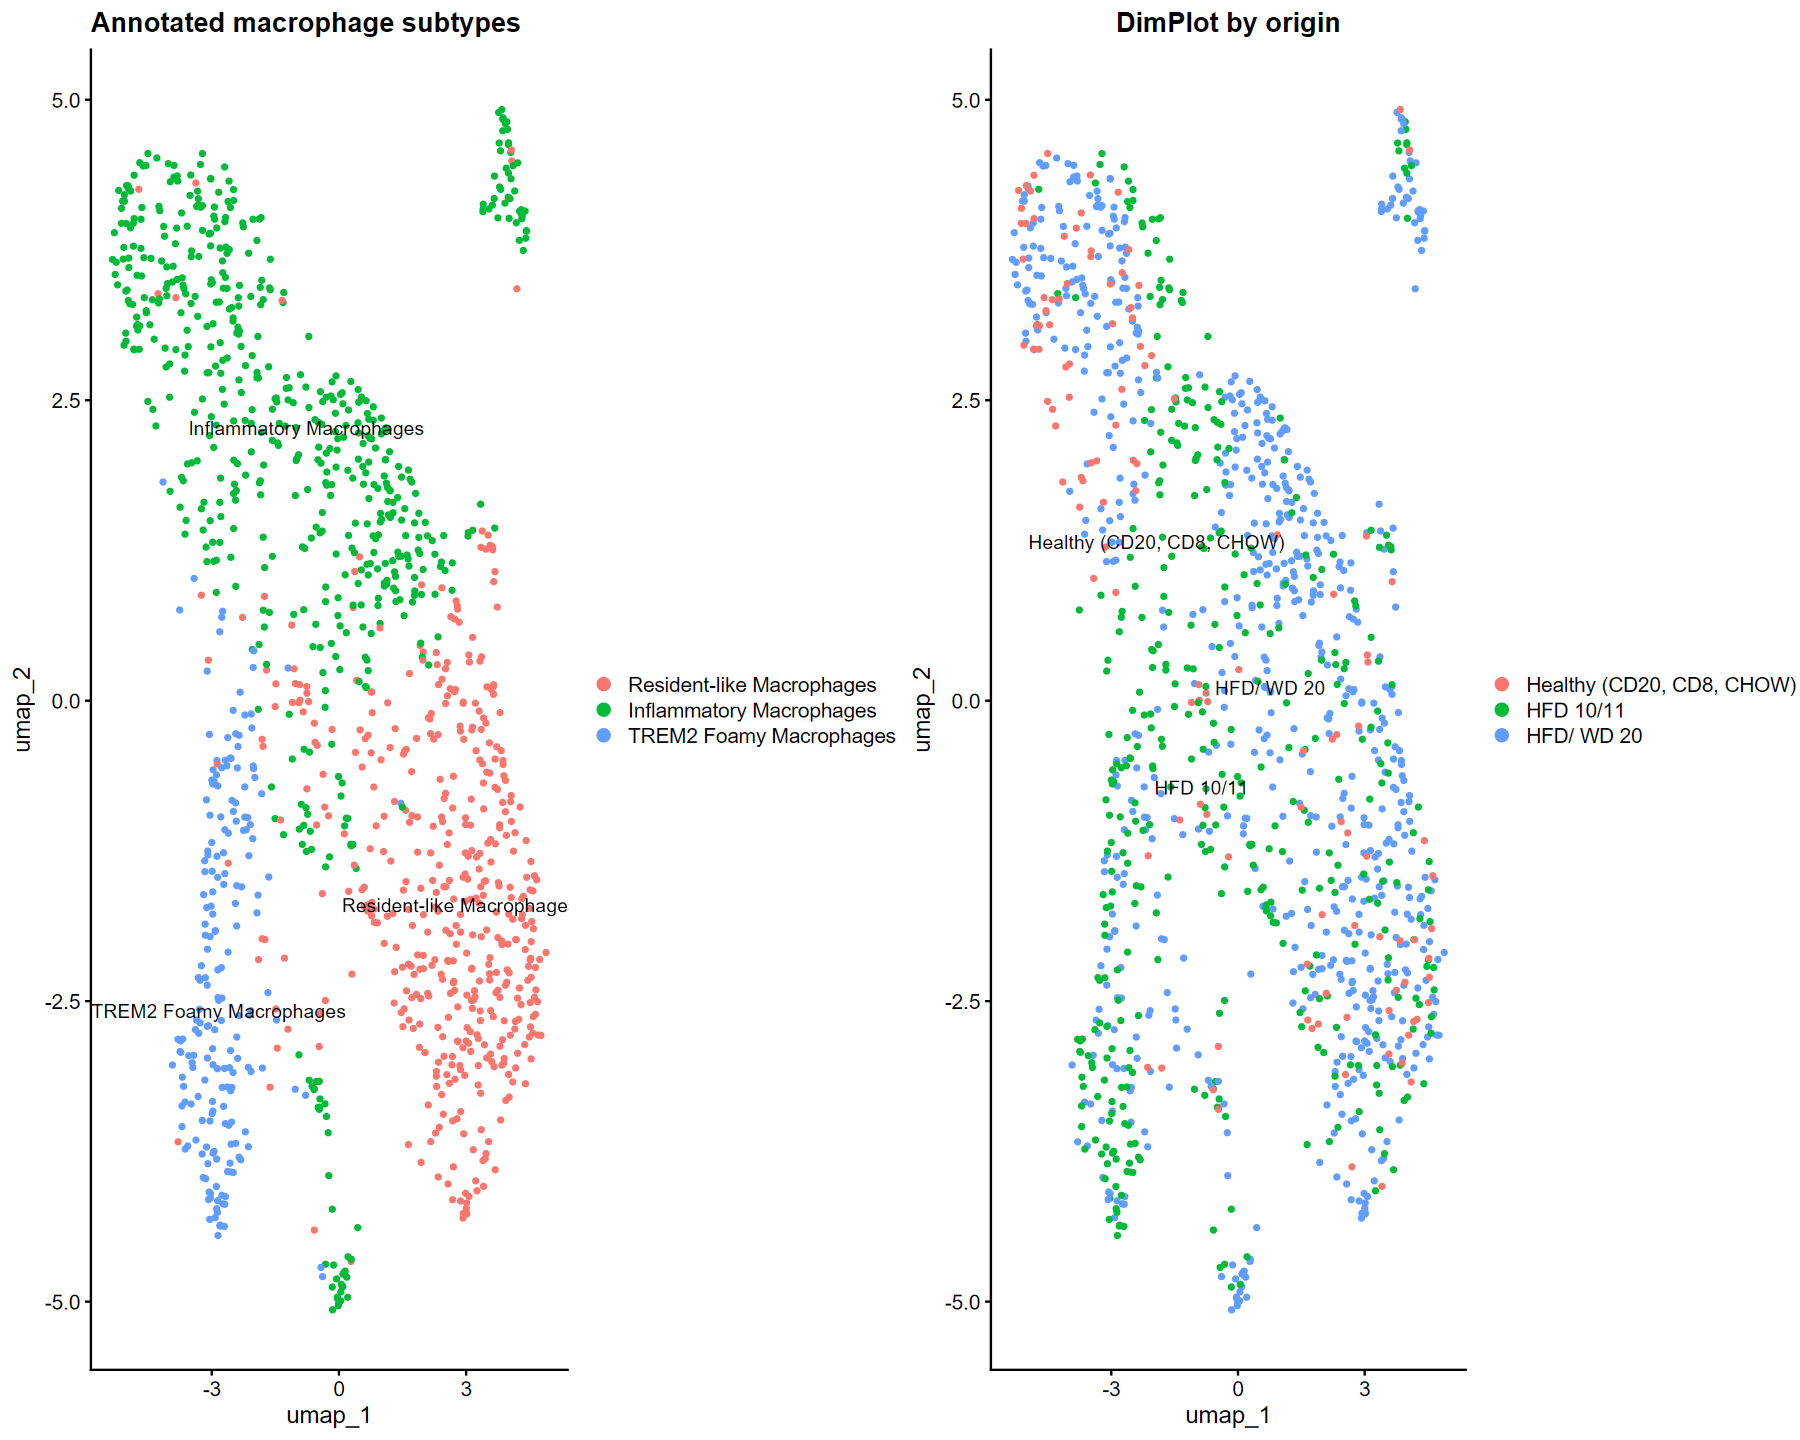

In [37]:
# Plot table
combined_df

# Plotting annotations and titles
grid.arrange(
    subtype_annotated_plot + ggtitle("Annotated macrophage subtypes"),
    subtype_origin_plot + ggtitle("DimPlot by origin"),
    ncol=2
)

In [38]:
# Save myeloid object
saveRDS(myeloid_data, file = "all_mice_myeloid.rds")